In [1]:
import sys

from FileTools import FileTools
# from pprint import pprint
from pathlib import Path
from zipfile import ZipFile
import pickle
#import random
import json
import time
import os

from IPython.display import display, HTML  # printing formatted DFs
from matplotlib import pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# authenticate with API

currWorkDir = os.getcwd()
userDir = Path.home()
keyPath = f"{userDir}\\PYC\\ADMIN\\kaggle.json"

with open( keyPath, 'r' ) as f: keyDict = json.load( f )
userTitle, keyTitle = keyDict.keys()
kaggleUsername, kaggleKey = keyDict[ userTitle ], keyDict[ keyTitle ]

os.environ[ 'KAGGLE_USERNAME' ] = kaggleUsername
os.environ[ 'KAGGLE_KEY' ] = kaggleKey

api = KaggleApi()
api.authenticate()


In [3]:
# retrieve dataset
datasetOwner = 'lucafrance'
datasetName = 'the-world-factbook-by-cia'
api.dataset_download_files( f'{datasetOwner}/{datasetName}', path="." )

# await download
fTools = FileTools()
datasetFName = None
print( "Waiting for dataset download" )
while True:
    time.sleep( 1 )
    sortedFs = fTools.datesortFiles( currWorkDir, datasetName )
    if len( sortedFs ) == 0: continue
    datasetFName = list( sortedFs )[ 0 ]
    print( f"Latest: {datasetFName}" )
    break

Waiting for dataset download
Latest: the-world-factbook-by-cia.zip


In [4]:
# extract and identify datafiles
origDataDir = f"{currWorkDir}\\data_or"
if not os.path.exists( origDataDir ): os.makedirs( origDataDir )
if datasetFName and Path( datasetFName ).suffix == ".zip":
    with ZipFile( datasetFName, 'r' ) as zipF: zipF.extractall( origDataDir )
dataPaths = [ f"{origDataDir}\\{pth}" for pth in os.listdir( origDataDir )
    if Path( pth ).suffix == ".csv" ]
if len( dataPaths ) > 0:
    dffBook = pd.read_csv( [ pth for pth in dataPaths ][ 0 ] )
    print( "Got dffBook DF from extracted dataset at:\n", dataPaths[ 0 ] )
else: print( "Failed get CSV" ); sys.exit()
dffBook

Got dffBook DF from extracted dataset at:
 C:\Users\romstroller\PYC\ciaFactBook\data_or\countries.csv


,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,https://www.cia.gov/the-world-factbook/countri...,Ahmad Shah DURRANI unified the Pashtun tribes ...,"Southern Asia, north and west of Pakistan, eas...","33 00 N, 65 00 E",Asia,"652,230 sq km","652,230 sq km",0 sq km,almost six times the size of Virginia; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,https://www.cia.gov/the-world-factbook/countri...,By terms of the 1960 Treaty of Establishment t...,"Eastern Mediterranean, peninsula on the southw...","34 37 N, 32 58 E",Middle East,123 sq km,NaN,NaN,"about 0.7 times the size of Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,https://www.cia.gov/the-world-factbook/countri...,Albania declared its independence from the Ott...,"Southeastern Europe, bordering the Adriatic Se...","41 00 N, 20 00 E",Europe,"28,748 sq km","27,398 sq km","1,350 sq km",slightly smaller than Maryland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,https://www.cia.gov/the-world-factbook/countri...,Algeria has known many empires and dynasties s...,"Northern Africa, bordering the Mediterranean S...","28 00 N, 3 00 E",Africa,"2,381,740 sq km","2,381,740 sq km",0 sq km,slightly less than 3.5 times the size of Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,https://www.cia.gov/the-world-factbook/countri...,Tutuila was settled by 1000 B.C. and the islan...,"Oceania, group of islands in the South Pacific...","14 20 S, 170 00 W",Oceania,224 sq km,224 sq km,0 sq km,"slightly larger than Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,https://www.cia.gov/the-world-factbook/countri...,The landlocked West Bank - the larger of the t...,"Middle East, west of Jordan, east of Israel","32 00 N, 35 15 E",Middle East,"5,860 sq km","5,640 sq km",220 sq km,slightly smaller than Delaware,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,https://www.cia.gov/the-world-factbook/countri...,"Globally, the 20th century was marked by: (a) ...",NaN,NaN,Physical Map of the World,510.072 million sq km,148.94 million sq km,361.9 million sq km,land area about 16 times the size of the US,...,there are 20 countries without rivers: 3 in Af...,"Caspian Sea (Azerbaijan, Iran, Kazakhstan, Rus...","the deepest lake in the world (1,620 m), and a...","Shanghai (China) - 43,303,000; Singapore (Sing...",the UN High Commissioner for Refugees (UNHCR) ...,"(44 countries) Armenia, Aruba, Azerbaijan, Bar...","(19 countries) Afghanistan, Algeria, Belarus, ...",worldwide coca cultivation in 2020 likely amou...,worldwide illicit opium poppy cultivation prob...,NaN
255,Yemen,https://www.cia.gov/the-world-factbook/countri...,The Kingdom of Yemen (colloquially known as No...,"Middle East, bordering the Arabian Sea, Gulf o...","15 00 N, 48 00 E",Middle East,"527,968 sq km","527,968 sq km",0 sq km,almost four times the size of Alabama; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 million (2019)
256,Zambia,https://www.cia.gov/the-world-factbook/countri...,Multiple waves of Bantu-speaking groups moved ...,"Southern Africa, east of Angola, south of 

In [5]:
def excludeParenth( _mtchLi, _val ):
    mtchLi = [ ]
    # # Drop value if between parentheses (pre-match open count > close count)
    for match in _mtchLi:
        matchDex = _val.index( match )
        openCount = _val[ :matchDex ].count( '(' )
        closCount = _val[ :matchDex ].count( ')' )
        parenthesised = openCount > closCount
        if not parenthesised: mtchLi.append( match )
    
    return mtchLi


def getMatchRemain( df_in, coIdex, patrn ):
    # take number-pattern match and save remainder for unit and scale
    mtches = df_in.iloc[ :, coIdex ].str.findall( patrn )
    
    pos = 0
    rmnder = [ ]
    mtches_ret = [ ]
    
    for roVal in df_in.iloc[ :, coIdex ]:
        matchLi = mtches[ pos ]
        if type( matchLi ) != list: rmnt = None  # is float; no remain
        elif len( matchLi ) == 1: rmnt = roVal
        # if more than one, truncate remainder before second match
        elif len( matchLi ) > 1: rmnt = roVal[ :roVal.index( matchLi[ 1 ] ) ]
        else: rmnt = None
        
        if rmnt:
            # exclude any parenthesised matches
            matchLi = excludeParenth( mtches[ pos ], roVal )
            mtches_ret.append( matchLi )
            if len( matchLi ) > 0:
                rmnder.append( rmnt.replace( matchLi[ 0 ], '' ) )
        else:
            if type( matchLi ) == float: mtches_ret.append( matchLi )
            else: mtches_ret.append( np.nan )
            rmnder.append( "" )
        
        pos += 1
    
    return mtches_ret, rmnder

In [6]:
# MATCHING NUMBERS
# REGEX:
#   capture group             (                 
#   zero/one                  [+-]?             possible number sign
#   1-3 nums                  \d{1,3}           up to three straight nums
#   non-capture subgroup      (?:               possible thousand-groups
#     comma and 3 nums          ,\d{3}          (sep. comma)
#     zero or more times        )*              
#   non-capture subgroup      (?:               then possible decimal part
#     decimal and 1+nums        \.\d+           
#     zero/one time             )?            
#   OR (alt. to last seq)     |                 or no groups, just              
#     0+ nums, dec, 1+nums      \d*\.\d+        more nums and poss decimal
#   OR (alt. to last seq)     |             
#     1+ nums                   \d+             or just more numbers.
#   Close capture group       )
#   ( match basic number last to capture greatest valid str segment )

patt = re.compile( r'([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d*\.\d+|\d+)' )

dfFbDict = { }  # collect column data
checkTypes = { }

colDex = 1
for colName in dffBook.columns[ colDex: ]:
    origCol = dffBook.iloc[ :, colDex ]
    colType = dffBook[ colName ].dtype
    
    # get match if string, store if already float, catch unexpected
    if colType == float:
        colDict = { 'matchedNums': origCol, 'remainder': [ ] }
    elif colType == np.float64:
        colDict = { 'matchedNums': origCol.astype( float ), 'remainder': [ ] }
    else:
        matches, remainder = getMatchRemain( dffBook, colDex, patt )
        colDict = { 'matchedNums': matches, 'remainder': remainder }
    
    colDict[ 'origCol' ] = origCol
    dfFbDict[ colName ] = colDict
    colDex += 1

In [7]:
# take first match item from list as float to "clean", store else to "split"
def splitFirstOther( matchList ):
    firstVals, splitVals, checkVals = [ ], [ ], [ ]
    for mNum in range( len( matchList ) ):
        el = matchList[ mNum ]
        isFilldList = (type( el ) == list) and (len( el ) > 0)
        if isFilldList:  # remove any thousandcomma to support convert
            firstVals.append( float( ''.join( el[ 0 ].split( ',' ) ) ) )
            splitVals.append( [ v for v in el[ 1: ] ] )
        else:  # check all else are either nan or empty matchlist
            if ((type( el ) == list and len( el ) > 0) or
                (type( el ) != list and math.isnan( el ) == False)):
                checkVals.append( el )
            firstVals.append( np.nan )
            splitVals.append( np.nan )
    return firstVals, splitVals, checkVals


for colName in dfFbDict:
    colDict = dfFbDict[ colName ]
    colDict[ 'clean' ], colDict[ 'splitVals' ], colDict[ 'checkVals' ] = (
        splitFirstOther( colDict[ 'matchedNums' ] ))

# Raise message if got uncategorized data
for colName in dfFbDict:
    if len( dfFbDict[ colName ][ 'checkVals' ] ) > 0:
        print( f"Got checkvals for {colName}" )

Got checkvals for People and Society: Dependency ratios - total dependency ratio
Got checkvals for People and Society: Dependency ratios - youth dependency ratio
Got checkvals for People and Society: Dependency ratios - elderly dependency ratio
Got checkvals for Transportation: Airports - with unpaved runways - over 3,047 m
Got checkvals for Geography: Land boundaries - metropolitan France - total
Got checkvals for Geography: Land boundaries - French Guiana - total


In [8]:
# dictionary columns to DF, checking is now float
newCols = [ ]
dfFloat = dffBook.iloc[ :, 0 ]  # start with countries
for colName in dfFbDict:
    clean = pd.Series( dfFbDict[ colName ][ 'clean' ] )
    lenFloat = len( [ i for i in clean if type( i ) == float ] )
    if lenFloat > len( clean ) * 0.90:
        newCols.append( colName )
        dfFloat = pd.concat( [ dfFloat, clean ], axis=1 )
    else: print( "col is less than 90% float. Dropping..." )

dfFloat.columns = [ 'Country' ] + newCols
dfFloat

,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,NaN,174.0,NaN,33.0,NaN,652230.000,652230.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,NaN,196.0,NaN,34.0,NaN,123.000,NaN,NaN,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,191.0,NaN,41.0,NaN,28748.000,27398.00,1350.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,NaN,150.0,NaN,28.0,NaN,2381740.000,2381740.00,0.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,NaN,100.0,NaN,14.0,NaN,224.000,224.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,NaN,15.0,NaN,32.0,NaN,5860.000,5640.00,220.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,NaN,20.0,NaN,NaN,NaN,510.072,148.94,361.9,16.0,...,20.0,372960.0,NaN,43303000.0,202.0,NaN,NaN,202.0,265000.0,NaN
255,Yemen,NaN,191.0,NaN,15.0,NaN,527968.000,527968.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
256,Zambia,NaN,188.0,NaN,15.0,NaN,752618.000,743398.00,9220.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Enforce non-nan threshold for dimensions

def nanThreshold( notNan ):  # average plus .5 standard deviation (rounded)
    return int( (sum( notNan ) / len( notNan )) + 0.5 * np.std( notNan ) )


def nonNanFromDims( dfr, dim = 1 ):
    nonNans = [ ]
    for pos in range( 0, dfr.shape[ dim ] ):
        if dim == 1: vals = dfr.iloc[ :, pos ].tolist()
        else: vals = dfr.loc[ [ pos ] ].values.tolist()[ 0 ]
        
        nonNans.append( [ vals, len( [ v for v in vals if
            type( v ) == float and not math.isnan( v ) ] ) ] )
    
    _thresh = nanThreshold( [ nval for _, nval in nonNans ] )
    keepVals = [ kval for kval, nnul in nonNans if nnul >= _thresh ]
    print( f"non-nan[ {len( keepVals )} ] thr[ {_thresh} ] dim[ {dim} ]" )
    
    return keepVals

In [10]:
# DROP ROWS - disabled to keep all significant countries
def cleanRows():
    dfClean = pd.DataFrame( nonNanFromDims( dfFloat, dim=0 ) )
    # add a columnindex row to track names of kept columns
    dfClean.loc[ -1 ] = dfFloat.columns
    dfClean.index = dfClean.index + 1
    dfClean.sort_index( inplace=True )
    return dfClean

# dfRowsClean = cleanRows()
# keepCols_RC = nonNanFromDims( dfRowsClean, dim=1 )
# # convert to numeric df - row-cleaned
# dfRCC = pd.DataFrame( { col[ 0 ]: col[ 1: ] for col in keepCols_RC } )
# dfRCC = dfRCC.apply( pd.to_numeric, errors='ignore' )
# dfColsClean = dfRCC

In [11]:
# CLEAN COLS to numeric, adding featname row for tracking through clean
dfFloat.loc[ -1 ] = dfFloat.columns
dfFloat.index = dfFloat.index + 1
dfFloat.sort_index( inplace=True )
keepCols = nonNanFromDims( dfFloat, dim=1 )
dfColsClean = pd.DataFrame( { col[ 0 ]: col[ 1: ] for col in keepCols } )
dfColsClean = dfColsClean.apply( pd.to_numeric, errors='ignore' )
dfColsClean.insert( 0, 'Country', dfFloat.iloc[ :, 0 ].tolist()[ 1: ] )
dfColsClean


non-nan[ 245 ] thr[ 93 ] dim[ 1 ]


,Country,Introduction: Background,Geography: Geographic coordinates,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,...,Government: Diplomatic representation from the US - telephone,Government: Diplomatic representation from the US - FAX,Economy: Credit ratings - Moody's rating,Communications: Telecommunication systems - note,Transportation: Railways - total,Transportation: Merchant marine - total,Transportation: Merchant marine - by type,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled,Geography: Maritime claims - exclusive economic zone
0,Afghanistan,174.0,33.0,652230.000,652230.00,0.0,5987.00,0.0,7492.0,258.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,196.0,34.0,123.000,NaN,NaN,48.00,56.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,191.0,41.0,28748.000,27398.00,1350.0,691.00,362.0,2764.0,0.0,...,355.0,355.0,1.0,-19.0,677.0,70.0,47.0,NaN,NaN,NaN
3,Algeria,150.0,28.0,2381740.000,2381740.00,0.0,6734.00,998.0,2908.0,-40.0,...,213.0,213.0,NaN,-19.0,3973.0,114.0,1.0,990299.0,8.0,NaN
4,American Samoa,100.0,14.0,224.000,224.00,0.0,0.00,116.0,964.0,0.0,...,NaN,NaN,NaN,-19.0,NaN,NaN,NaN,NaN,NaN,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,15.0,32.0,5860.000,5640.00,220.0,478.00,0.0,1020.0,-431.0,...,NaN,NaN,NaN,-19.0,NaN,NaN,NaN,6935.0,0.5,NaN
254,World,20.0,NaN,510.072,148.94,361.9,NaN,356000.0,8849.0,-3500.0,...,NaN,NaN,NaN,NaN,1148186.0,98202.0,12319.0,NaN,NaN,NaN
255,Yemen,191.0,15.0,527968.000,527968.00,0.0,1601.00,1906.0,3666.0,0.0,...,966.0,966.0,NaN,-19.0,NaN,34.0,2.0,386946.0,8.0,200.0
256,Zambia,188.0,15.0,752618.000,743398.00,9220.0,6043.15,0.0,2330.0,329.0,...,260.0,260.0,NaN,-19.0,3126.0,2.0,1.0,NaN,NaN,NaN


In [12]:
# Review clean DF
fbIsNa = dffBook.isna().sum().sum()
dfIsNa = dfColsClean.isna().sum().sum()
fbDim = dffBook.shape[ 0 ] * dffBook.shape[ 1 ]
dfDim = dfColsClean.shape[ 0 ] * dfColsClean.shape[ 1 ]
print( f"factbook originally shape: {dffBook.shape}" )
print( f"    NAN-density: {(fbIsNa / fbDim):.2f}% "
       f"({fbIsNa} NaN in {fbDim})" )
print( f"clean dataframe has shape: {dfColsClean.shape}" )
print( f"    NAN-density: {(dfIsNa / dfDim):.2f}% "
       f"({dfIsNa} NaN in {dfDim})" )

factbook originally shape: (258, 1054)
    NAN-density: 0.74% (200708 NaN in 271932)
clean dataframe has shape: (258, 246)
    NAN-density: 0.22% (14038 NaN in 63468)


In [13]:
# CHECK FOR SCALE FACTORS / FEATURE ANALYSIS/SELECTION CYCLE

def runScaleAnalysis( dfr, remDict ):
    colList = list( dfr.columns )
    dropFeatrs = [ ]
    cleanNotes = { }
    
    for pos in range( 1, len( colList ) ):
        colNam = colList[ pos ]
        colSeg = dfr.iloc[ :, pos ].tolist()[ :10 ]
        remndr = set( remDict[ colNam ] )
        rMainPrint = ""
        for r in list( remndr )[ :25 ]:
            if type( r ) == float: rMainPrint = rMainPrint + f"{r}\n"
            else: rMainPrint = rMainPrint + f"{r[ :60 ]}\n"
        
        report = (f"COL [ {pos} ] {colNam}\n\n"
                  f"CLEANVALS:\n{colSeg}\n\n"
                  f"REMAINDER (unq in col: {len( remndr )}):\n{rMainPrint}\n")
        
        report_a = report + "\nACCEPT(A), BREAK(B), CLEAN/SCALE NOTE(C), DROP(D)"
        report_b = report_a + "\n\nPLEASE MAKE A SELECTION:\n\n"
        usinp = input( report_a )
        while usinp not in [ 'a', 'd', 'c', 'b' ]: usinp = input( report_b )
        if usinp == 'b': break
        elif usinp == 'a': continue
        elif usinp == 'd': dropFeatrs.append( colNam )
        else: cleanNotes.update( {
            colNam: input( f"{report[ :250 ]}...\n\n\nCLEANING/SCALE NOTE" ) } )
    
    return dropFeatrs, cleanNotes

# dropFeatrs, cleanNotes = runScaleAnalysis(dfColsClean, cleanReman)

In [14]:
# # SAVE SCALE ANALYSIS DATA
# stmp = fTools.dtStamp()
# fTools.storePKL( dropFeatrs, f'dropFeatrs_{stmp}', currWorkDir, subdir=None )
# fTools.storePKL( cleanNotes, f'cleanNotes_{stmp}', currWorkDir, subdir=None )

In [15]:
# LOAD SCALE ANALYSIS DATA
pklFiles = [ fi for fi in
    [ open( pth, 'rb' ) for pth in
        [ list( dKey )[ 0 ] for dKey in
            [ fTools.datesortFiles( currWorkDir, fNam ) for fNam in
                [ 'dropFeatrs', 'cleanNotes' ] ] ] ] ]

dropFeats, scaleNotes = [ pickle.load( fi ) for fi in pklFiles ]
for fi in pklFiles: fi.close()

In [16]:
# DROP DROPFEATS
df = dfColsClean.copy()
for i in dropFeats:
    try: df.drop( [ i ], axis=1, inplace=True )
    except KeyError: pass
scaleKeys = [ dkey for dkey in scaleNotes if dkey not in dropFeats ]


In [17]:
# update value by matching remainder scale fragment via country reference

dct = dfFbDict.copy()

scaleDict = {
    "million": 1000000,
    "billion": 1000000000,
    "trillion": 1000000000000 }

cleanCountries = list( df[ 'Country' ] )

for colName in scaleKeys:
    colVals = [ ]
    row = 0
    
    # checking remnantcol (HAS PRE-CLEAN ENTRIES) for match
    for remnt in dct[ colName ][ 'remainder' ]:
        # print( remnt, "___" )
        country = dffBook[ 'Country' ][ row ]
        if country not in cleanCountries: row += 1; continue
        val = df.loc[ df[ 'Country' ] == country ][ colName ].iloc[ 0 ]
        if type( remnt ) == float: row += 1; colVals.append( val ); continue
        if remnt.startswith( "-$" ): val = 0 - val  # fix $ breaking neg float
        
        matches = [ ]
        for scale in scaleDict:  # apply lowest-index matched scale
            try: matches.append( [ remnt.index( scale ), scale ] )
            except ValueError: continue
        if len( matches ) > 0:  # sort by lowest index (first val of match)
            matchScale = sorted( matches, key=lambda x: x[ 0 ] )[ 0 ][ 1 ]
            val = val * scaleDict[ matchScale ]
        
        colVals.append( val )
        row += 1
    
    df[ colName ] = colVals

pd.options.display.float_format = '{:,.2f}'.format
df


,Country,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,Geography: Elevation - mean elevation,Geography: Land use - agricultural land,...,Transportation: Heliports,Transportation: Roadways - total,Transportation: Roadways - paved,Transportation: Roadways - unpaved,Military and Security: Military expenditures,Military and Security: Military and security service personnel strengths,Transportation: Railways - total,Transportation: Merchant marine - total,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled
0,Afghanistan,"652,230.00","652,230.00",0.00,"5,987.00",0.00,"7,492.00",258.00,"1,884.00",58.10,...,1.00,"34,903.00","17,903.00","17,000.00",3.30,"58,000.00",NaN,NaN,NaN,NaN
1,Akrotiri,123.00,NaN,NaN,48.00,56.30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,"28,748.00","27,398.00","1,350.00",691.00,362.00,"2,764.00",0.00,708.00,42.80,...,NaN,"3,945.00",NaN,NaN,1.40,"8,000.00",677.00,70.00,NaN,NaN
3,Algeria,"2,381,740.00","2,381,740.00",0.00,"6,734.00",998.00,"2,908.00",-40.00,800.00,17.40,...,4.00,"104,000.00","71,656.00","32,344.00",5.60,"140,000.00","3,973.00",114.00,"990,299.00",8.00
4,American Samoa,224.00,224.00,0.00,0.00,116.00,964.00,0.00,NaN,24.50,...,NaN,241.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,"5,860.00","5,640.00",220.00,478.00,0.00,"1,020.00",-431.00,NaN,43.30,...,1.00,"4,686.00","4,686.00",NaN,NaN,"30,000.00",NaN,NaN,"6,935.00",0.50
254,World,"510,072,000.00","148,940,000.00","361,900,000.00",NaN,"356,000.00","8,849.00","-3,500.00",840.00,NaN,...,"6,524.00",NaN,NaN,NaN,2.40,20.00,"1,148,186.00","98,202.00",NaN,NaN
255,Yemen,"527,968.00","527,968.00",0.00,"1,601.00","1,906.00","3,666.00",0.00,999.00,44.50,...,NaN,"71,300.00","6,200.00","65,100.00",4.00,"300,000.00",NaN,34.00,"386,946.00",8.00
256,Zambia,"752,618.00","743,398.00","9,220.00","6,043.15",0.00,"2,330.00",329.00,"1,138.00",31.70,...,NaN,"67,671.00","14,888.00","52,783.00",1.30,"17,000.00","3,126.00",2.00,NaN,NaN


In [18]:
# remove "World" until needed
dfWorld = df[ df.Country == 'World' ].copy()
df = df[ df.Country != 'World' ].copy()

## a few top and bottom tens

In [19]:
# need to go back and get units
# make a class with methods:
#   x.showBar(asc=x)
#   x.gett10(asc=x)
#   x.getCol(asc=x)
#   x.getDF(asc=x)

def showTopTen( featName, _df, asc = False, subtitle = None, unit = None ):
    print( featName )
    
    df10 = pd.concat( [ _df[ 'Country' ],
        pd.Series( _df[ featName ] ) ], axis=1 ).sort_values( by=[ featName ],
        ascending=asc )[ :10 ]
    
    fig = plt.figure( facecolor="silver" )
    ax = fig.add_axes( [ 0, 0, 1.2, 1.2 ] )
    ax.bar( df10.iloc[ :, 0 ], df10.iloc[ :, 1 ] )
    
    title = f"{'BOTTOM' if asc else 'TOP'} TEN\n{featName}"
    if subtitle: title = f"{title}\n({subtitle})"
    if unit: title = f"{title}\n[{unit}]"
    
    ax.set_title( title, fontsize=16, ha="right", weight="demi", x=0.98,
        color="black" )
    
    ax.ticklabel_format( axis='y', useOffset=False, style='plain' )
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize( 14 )
        tick.label.set_color( 'black' )
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize( 14 )
        tick.label.set_color( 'black' )
    
    plt.xticks( rotation=45, ha='right' )
    
    plt.show()


Geography: Area - total


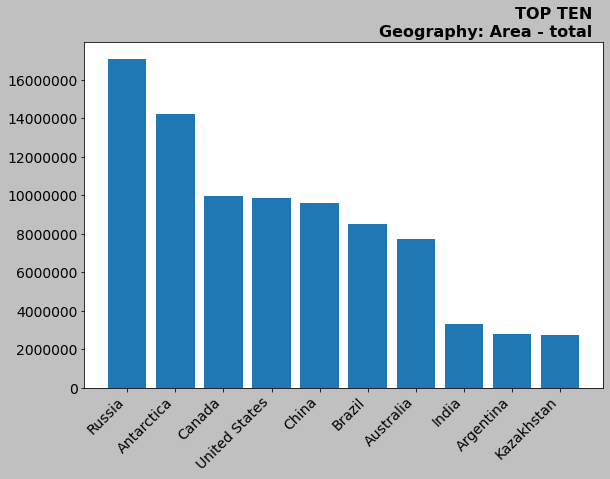

In [20]:
# largest countries. 
showTopTen( 'Geography: Area - total', df )
# Some thoughts:
#   The invasion of Ukraine should not be considered an act of 
#       ordinary claustrophobia
#   Antarctica: what is it good for?
#   Looking at sovereign territories as real-estate for future resources [..]
#   ...


Water-area ratio


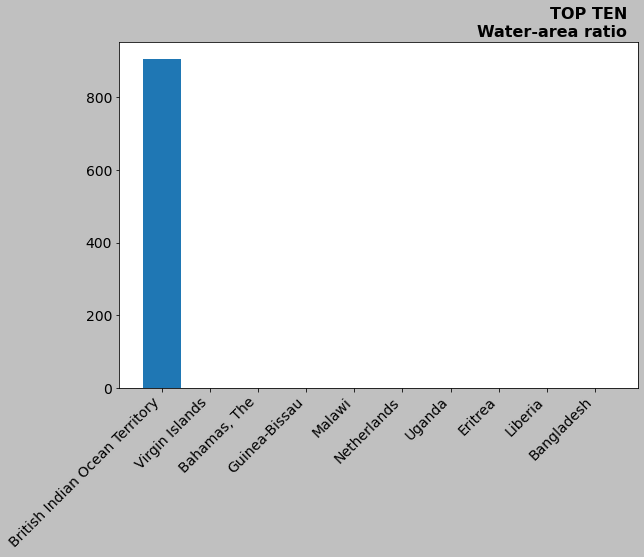

In [21]:

# highest percent water area
df[ 'Water-area ratio' ] = (
    df[ 'Geography: Area - water' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Water-area ratio', df )
# The British Indian Ocean territory data here is an outlier arising from an
#   apparent inconsistency or ambiguity in geographic description - 
#   the territory is designated across a very sparse grouping of islands which 
#   are themselves thin segments of atolls or whole/partial atolls with large 
#   inner bodies of water. Some interesting reading both for observers of 
#   colonialism and for ongoing events in the projection of sovereign power 
#   across large sea vectors:

#### British Indian Ocean Territory
![British_Indian_Ocean_Territory](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/British_Indian_Ocean_Territory_in_United_Kingdom.svg/1466px-British_Indian_Ocean_Territory_in_United_Kingdom.svg.png)

WIKI: 
>The only inhabitants are British and U.S. military personnel and associated 
contractors, who collectively number around 3,000 (2018 figures). The 
forced removal of Chagossians from the Chagos Archipelago occurred between 
1968 and 1973. [...] Today, the exiled Chagossians are still trying 
to return, saying that the forced expulsion and dispossession was unlawful, 
but the UK government has repeatedly denied them the right of return. The 
islands are off-limits to Chagossians, casual tourists, and the media. 



Water-area ratio


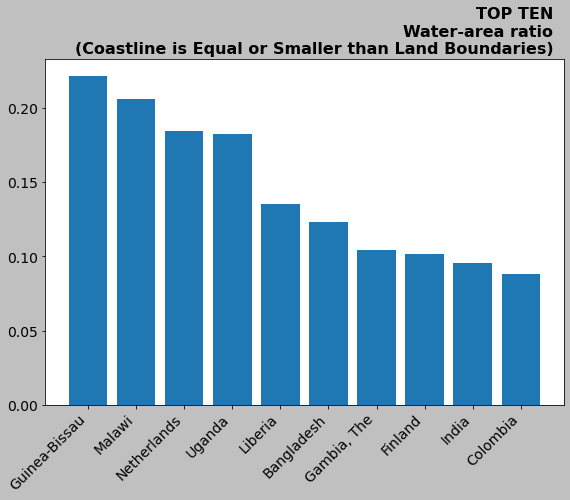

Water-area ratio


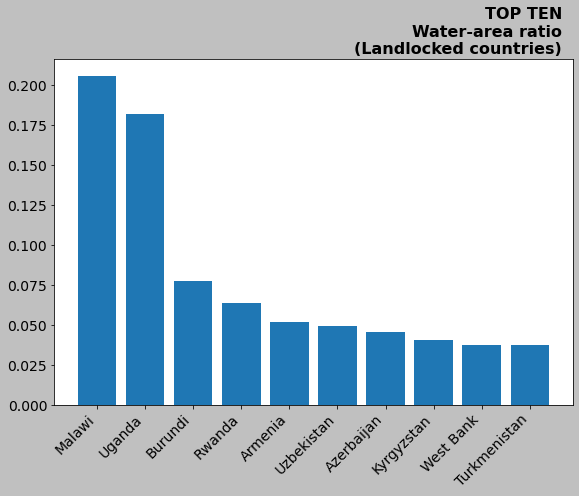

In [22]:
# In the course of this study, small island groups with colonial-territorial 
# names I'm not familiar with keep showing up. Would like to dive into more 
# detail on each of these; adding "Ashmore and Cartier Islands" to the list.

ctIslands = [ 'British Indian Ocean Territory', "Ashmore and Cartier Islands" ]

# Excluding BIOT as an outlier should reveal a more intuitive distribution.
# Better yet, to avoid catching so many islands, let's filter down to countries 
# whose coastline is no longer than their land boundaries with other countries.

showTopTen( 'Water-area ratio',
    df[ df[ 'Geography: Land boundaries - total' ] >=
        df[ 'Geography: Coastline' ] ],
    subtitle="Coastline is Equal or Smaller than Land Boundaries" )

# Just out of curiosity (good name for a blog?), the stats for completely
# landlocked countries:

showTopTen( 'Water-area ratio',
    df[ df[ 'Geography: Coastline' ] == 0 ],
    subtitle="Landlocked countries" )

Geography: Coastline


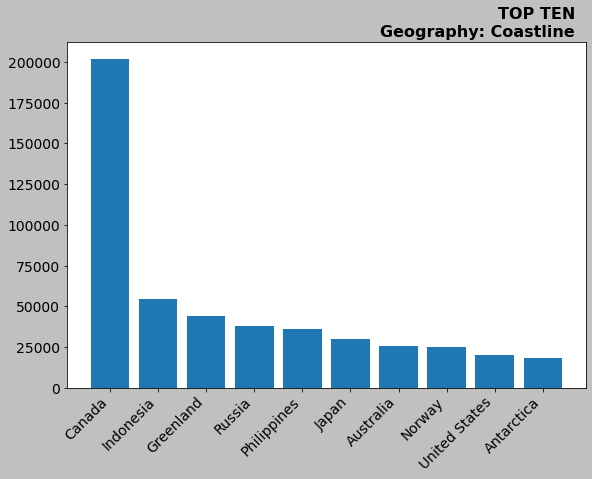

In [23]:
# It should be safe to posit that Canada is likely at least somewhat well-known 
# as a destination for those people with metal detectors you always see a few 
# hundred meters away at the beach.
showTopTen( 'Geography: Coastline', df )

Maximum elevation difference


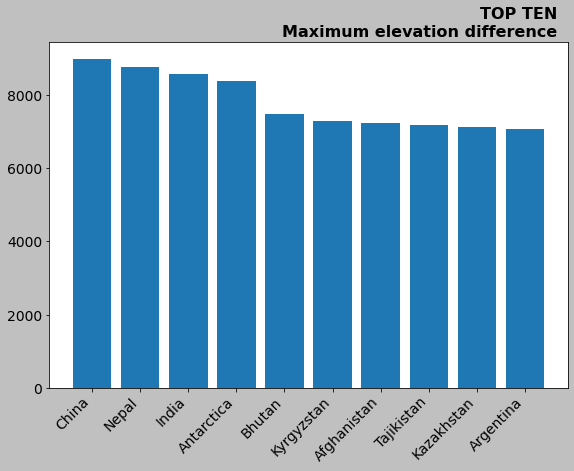

Maximum elevation difference


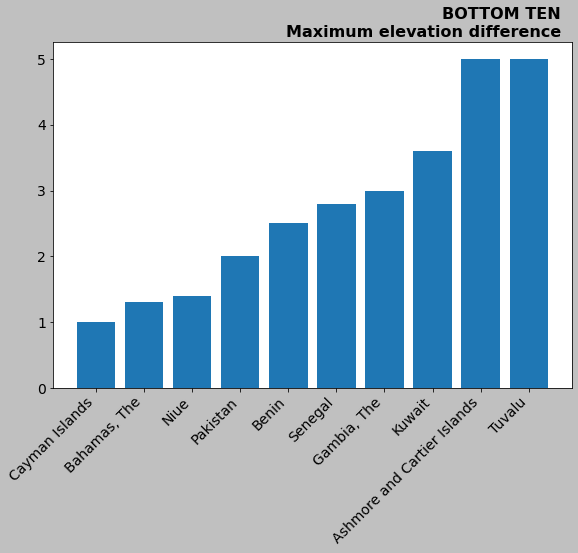

In [24]:
# countries with the largest difference between their lowest and highest point
# 'stans represent!
# while the China-Nepal border dissects Siggamartha's highest point, China 
# itself has a lower minimum elevation than Nepal.
df[ 'Maximum elevation difference' ] = (
    df[ 'Geography: Elevation - highest point' ] -
    df[ 'Geography: Elevation - lowest point' ])
showTopTen( 'Maximum elevation difference', df )

# Flattest places in the world: no point on natural ground is at an ascent of 
#   more of than five meters from any other point.
#   Cayman Islands is easiest on the hips with an M.E.D of one meter
showTopTen( 'Maximum elevation difference', df, asc=True )

# another for the ctIslands list:
ctIslands.append( 'Ashmore and Cartier Islands' )


People and Society: Age structure - 65 years and over


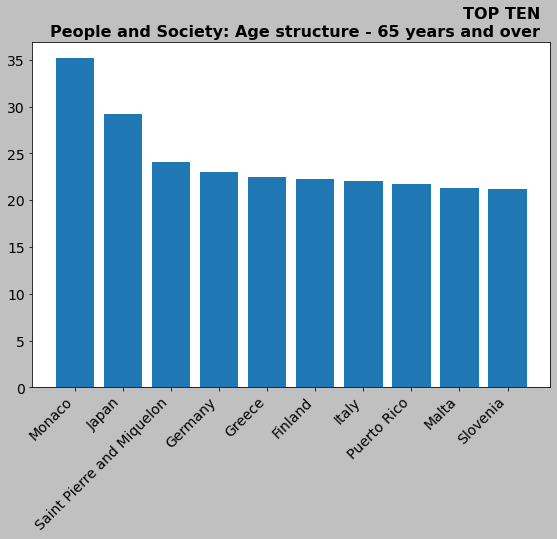

People and Society: Dependency ratios - potential support ratio


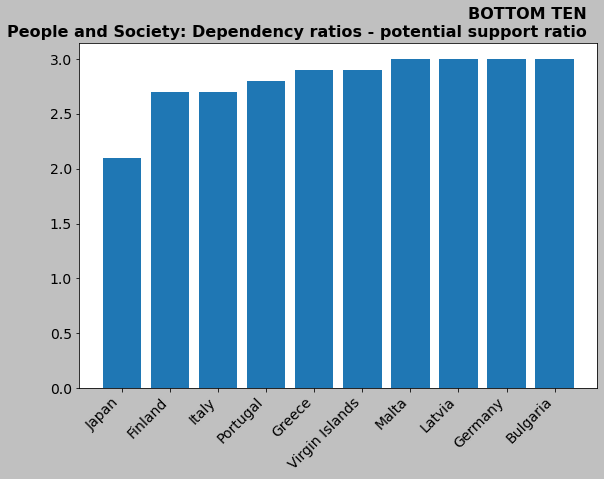

In [25]:
# highest percent of population in the 65+ bracket 
# Monaco and then Japan both stand conspicuously out from the distribution
# My speculation is that it would tend to be an older people who can afford 
#   Monaco's prestigious cost of living while, on the other hand, Japan has a 
#   culturally restrained birth rate - young adults tend to prioritize career 
#   ascension over family-making (cite).
showTopTen( 'People and Society: Age structure - 65 years and over', df )
# Japan takes the lead with % younger adults who might be able to 
#   take on a supporting role to the elderly, while Monaco, having more to
#   do the looking-after, is not in the bottom-ten for support ratio.
showTopTen( 'People and Society: Dependency ratios - potential support ratio',
    df, asc=True )

# another for the ctIslands list, a "remaining vestige of the once vast 
# territory of New France"; also one of the fastest-decreasing pop-rates (#4)
ctIslands.append( 'Saint Pierre and Miquelon' )

Irrigated-area ratio


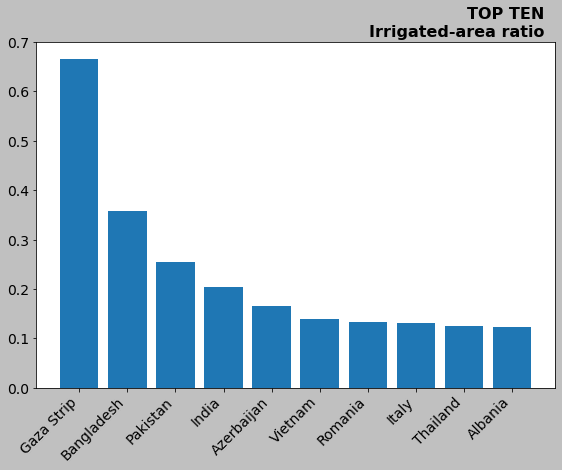

Irrigated area in Gaza Strip is 0.6666666666666666 km


In [26]:
# Ratio of irrigated land to total land
df[ 'Irrigated-area ratio' ] = (
    df[ 'Geography: Irrigated land' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Irrigated-area ratio', df )


# Not surprised about most of the t10, who largely have a pastoral image,
#   but the Gaza Strip strikes one as being either desert or concrete. 
#   Still can be mostly true - Gaza as leader is still under 0.6%; an easy
#   threshold to reach given its small proportions.


def getVal( _df, _ctry, _feat ):
    return _df.loc[ _df[ 'Country' ] == _ctry, _feat ].iloc[ 0 ]


print( f"Irrigated area in Gaza Strip is "
       f"{getVal( df, 'Gaza Strip', 'Irrigated-area ratio' )} km" )

#   Some reading on esyrt in Palestinian agriculture: 
#       https://socialsciences.mcmaster.ca/kubursi/ebooks/water.htm

People and Society: Population growth rate


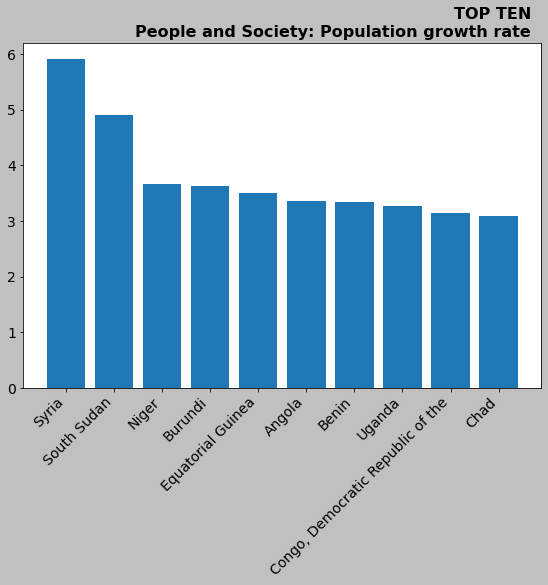

People and Society: Net migration rate


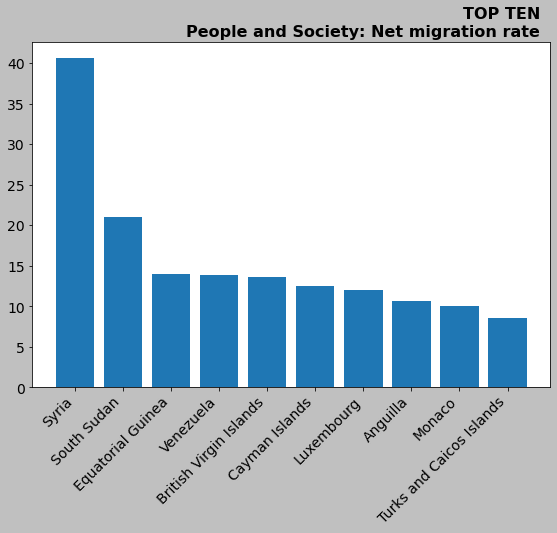

People and Society: Net migration rate


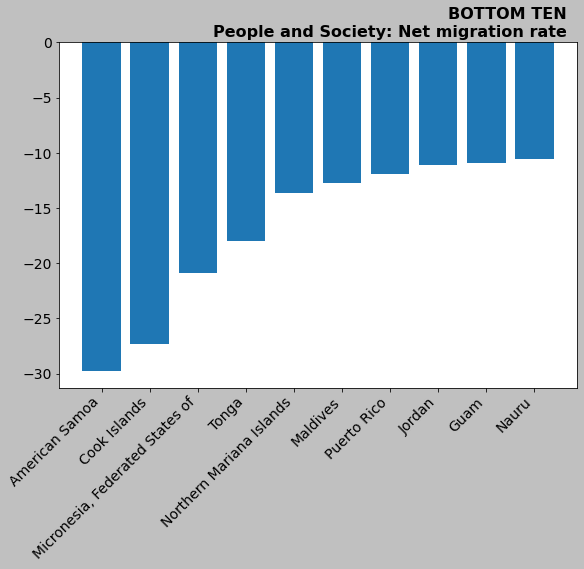

People and Society: Population growth rate


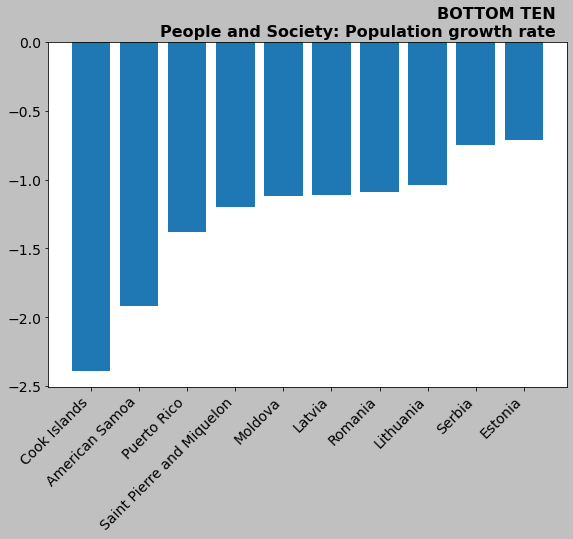

In [27]:
# Syria's ascendency in population growth must be linked to its even 
# greater leadership in net migration. What's the story there?
# (once the Cocos is excluded as an outlier. Also what's the story? 
#   In other sources the pop has not seemingly changed by anything like 100%)
#  Monaco receiving a steady stream of aspiring casino magnates

showTopTen( 'People and Society: Population growth rate', df )
showTopTen( 'People and Society: Net migration rate', df )

# Most emmigration, and populations in greatest contraction
# two very strong categories: either islands (esp. Pacific), or eastern Europe.
# (Jordan being the one exception)
showTopTen( 'People and Society: Net migration rate', df, asc=True )
showTopTen( 'People and Society: Population growth rate', df, asc=True )

# more for the ctIslands list
ctIslands.append( 'Cocos (Keeling) Islands' )
ctIslands.append( 'Anguilla' )
ctIslands.append( 'British Virgin Islands' )
ctIslands.append( 'Cayman Islands' )  # may as well get into these while we're here
ctIslands.append( 'Northern Mariana Islands' )



People and Society: Sex ratio - 25-54 years


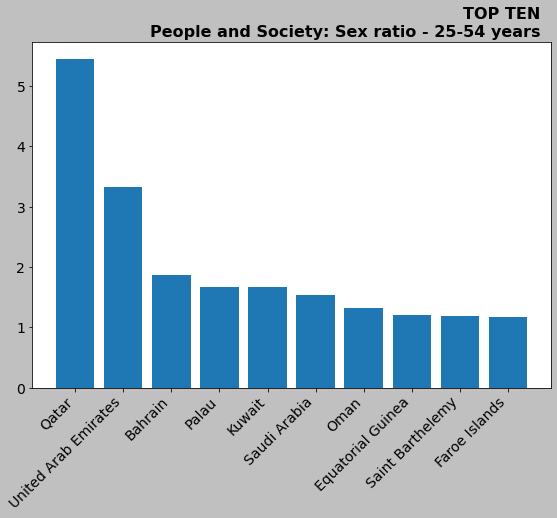

People and Society: Sex ratio - 55-64 years


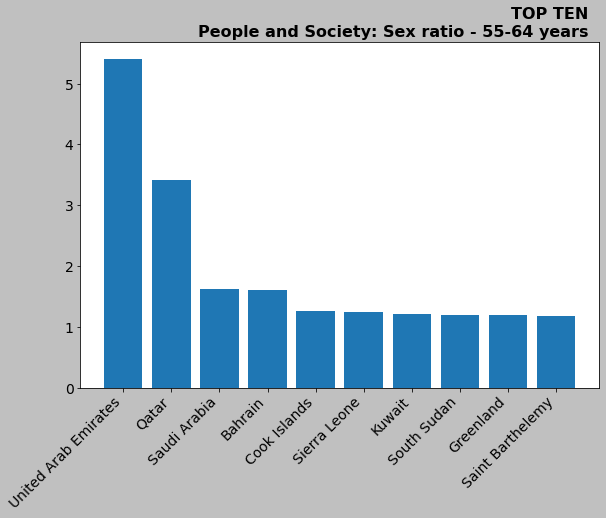

People and Society: Age structure - 25-54 years


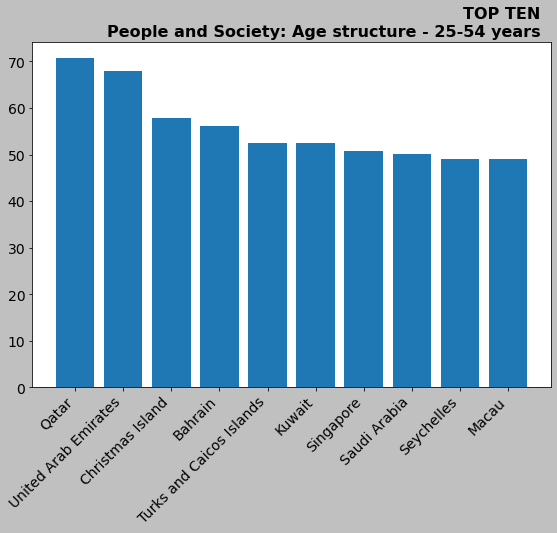

People and Society: Dependency ratios - potential support ratio


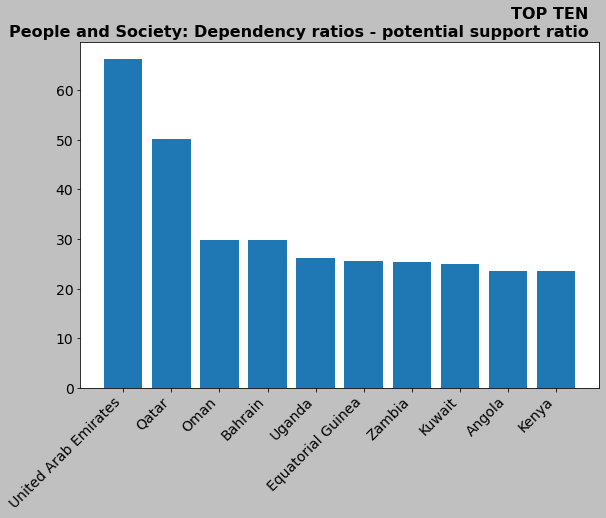

People and Society: Sex ratio - 65 years and over


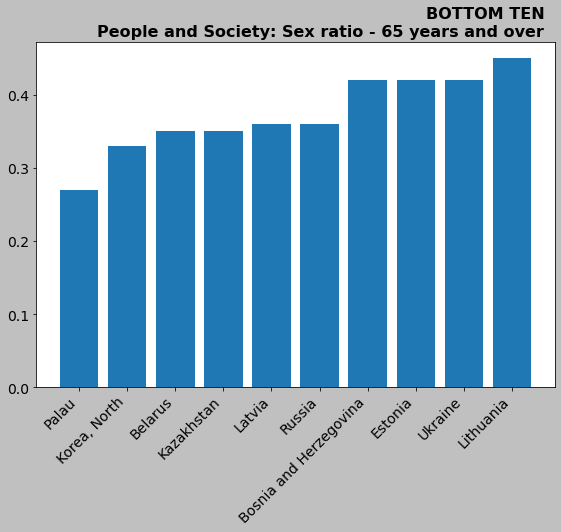

In [28]:
# Qatar & UAE's men-to-women ratios in the 25-54yo, 55-64yo and 65+ brackets 
# are startlingly weighted to men, the strongest in the world.
showTopTen( 'People and Society: Sex ratio - 25-54 years', df )
showTopTen( 'People and Society: Sex ratio - 55-64 years', df )
# At the same time, both have (by good measure) the highest value for
# the percentage of total population that is 25-54 years old.
showTopTen( 'People and Society: Age structure - 25-54 years', df )
# Interesting combination - purely speculating, one can imagine a dominating
# social discourse might concern the relation of older men to working-age adults.
# This consideration is furnished with the dependency ratio, in which
# UAE and Qatar are by very, very far the the world chart-toppers:
showTopTen( 'People and Society: Dependency ratios - potential support ratio', df )
# (What is the DR, and how would these three figures relate?)

# meanwhile, in Palau and North Korea, in the 65+ bracket, there are more than 
# twice as many old codgettes as old codgers.
showTopTen( 'People and Society: Sex ratio - 65 years and over', df, asc=True )

# for the Kooky Islands Krew
ctIslands.append( 'Saint Barthelemy' )
ctIslands.append( 'Faroe Islands' )
ctIslands.append( 'Turks and Caicos Islands' )

People and Society: Current Health Expenditure


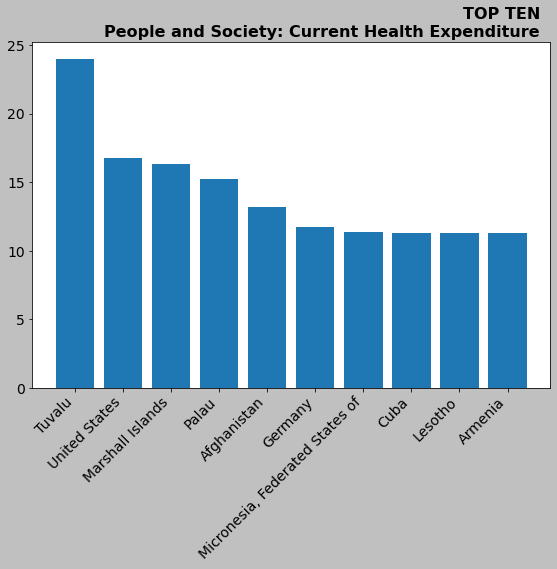

People and Society: Physicians density


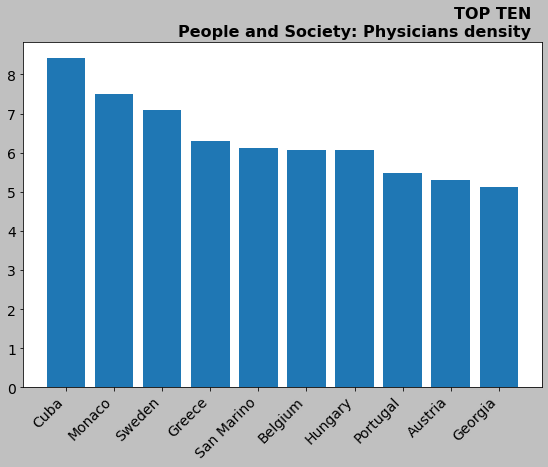

People and Society: Current Health Expenditure


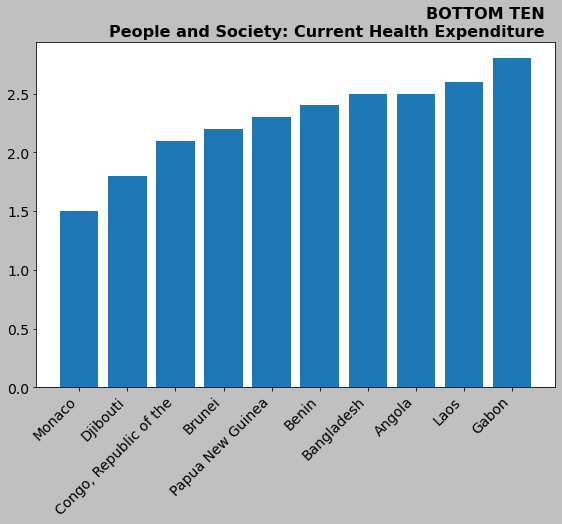

In [29]:
# People and Society: Current Health Expenditure
# Surprised to see US near the top with the impression given by private health 
# costs.
showTopTen( 'People and Society: Current Health Expenditure', df )
# Only one country in t10 expenditure is also in t10 physician density (Cuba)
showTopTen( 'People and Society: Physicians density', df )
# physician density strikes me as vital, as a population's relationship with
#   health-seeking, at a preventative stage, [is tied] to its familiarity and 
#   access to responsive human consultation.
# Nice littel one-liner aside: Cuba provides more medical personnel to the 
#   developing world than all the G8 countries combined.

# The only "first-world" country in bottom-10 health expenditure, indeed
#   leading it, is Monaco, which happens also to:
#       - have the second-highest physician density
#       - top the "% pop is 65+"
#   So, with such an old population and such a high density of physicians, 
#   it may be safe to assume that it is an excellent destination for 
#   private medical enterprise
showTopTen( 'People and Society: Current Health Expenditure', df, asc=True )

# for the Kooky Islands Krew
ctIslands.append( 'San Marino' )

People living with HIV/AIDs as percentage of population


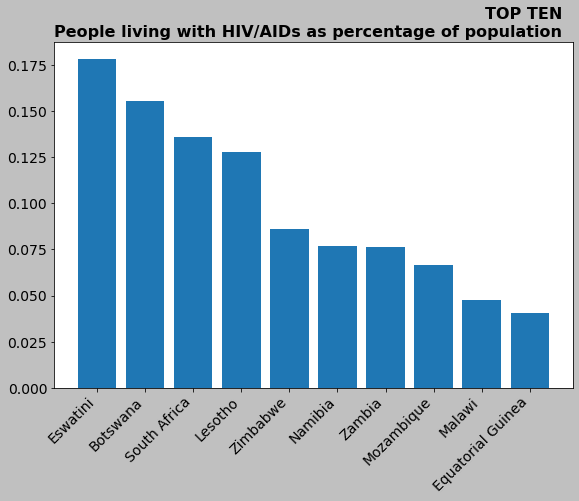

People living with HIV/AIDs as percentage of population


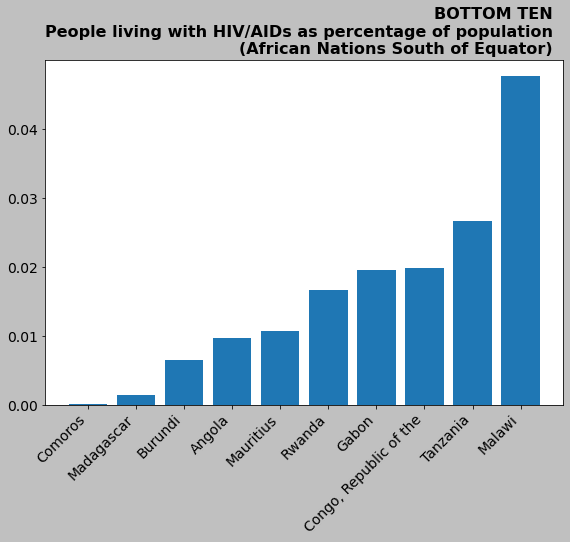

In [30]:
# Southern Africa nations exclusively form the t10 %pop with HIV-AIDs
df[ 'People living with HIV/AIDs as percentage of population' ] = (
    df[ 'People and Society: HIV/AIDS - people living with HIV/AIDS' ] /
    df[ 'People and Society: Population' ])
showTopTen( 'People living with HIV/AIDs as percentage of population', df )

# one becomes curious which SA nation has the lowest population with HIV/AIDs
sthEquatAfrica = dffBook[
    (dffBook[ "Geography: Map references" ] == "Africa")
    & (dffBook[ "Geography: Geographic coordinates" ].str.contains( "S" ))
].Country

showTopTen( 'People living with HIV/AIDs as percentage of population',
    df[ df[ 'Country' ].isin( sthEquatAfrica ) ], asc=True,
    subtitle="African Nations South of Equator" )

For the countries that are not islands, Angola - being large, and close to the
HIV/AIDs epicentre, appears to have some form of strongly inhibiting factor.
A look at recent history identifies a cause for the low prevalence: civil war. 

> The 27-year civil war in Angola, lasting from 1975 until 2002, kept the spread 
> of HIV to a minimum due to large parts of the country being inaccessible to 
> people infected with the virus. During the civil war, individuals from 
> neighboring countries such as Zambia, Botswana, and Zimbabwe (all countries 
> with high prevalence rates of HIV) were also not allowed to come into the 
> country, which played a significant role in controlling the spread of HIV.
> [(source: Wikipedia)](https://en.wikipedia.org/wiki/HIV/AIDS_in_Angola#History)



In [31]:
# more for the Kooky Islands Krew
ctIslands.append( 'Comoros' )
ctIslands.append( 'Sao Tome and Principe' )

People and Society: Tobacco use - total


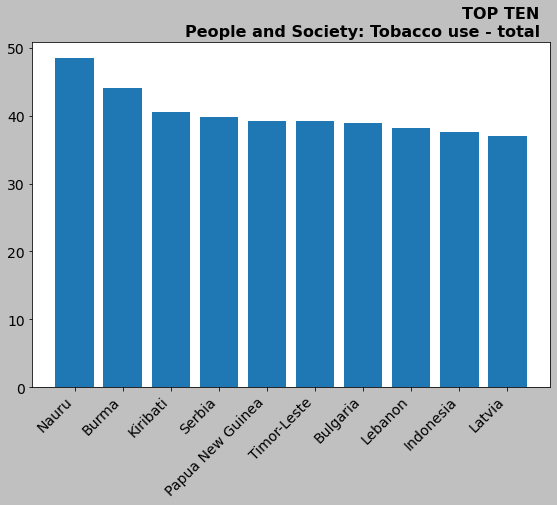

People and Society: Tobacco use - male


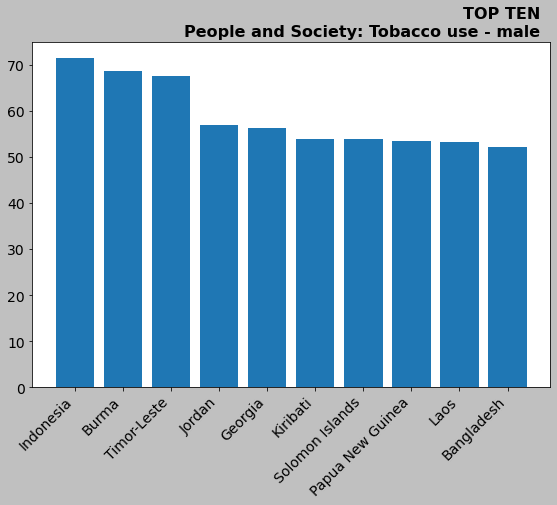

People and Society: Tobacco use - female


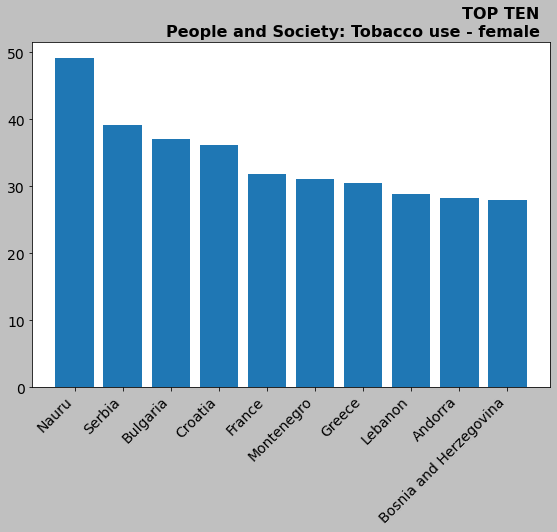

People and Society: Tobacco use - total


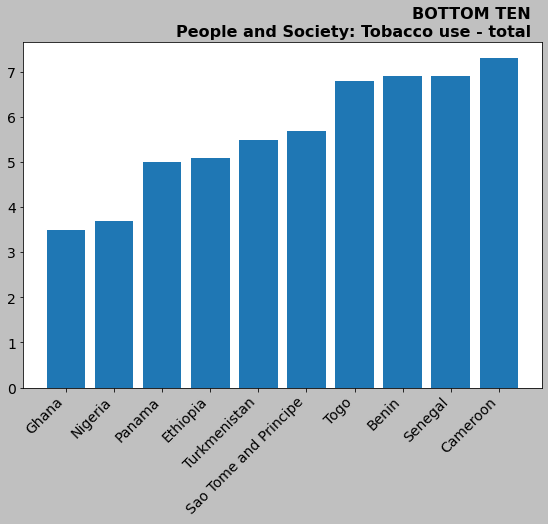

In [32]:
# Nearly half the people in Nauru and Burma smoke
showTopTen( 'People and Society: Tobacco use - total', df )
# However, when limited to females, whereas European nations remain in the t10,
# the Asia-Pacific nations Burma, Kiribati, Timor Leste, PNG and Indonesia 
# disappear ( whereas for men they remain).  
#   - Gender associations with the act of smoking? 
#     (eg.: "smoking is manly (positive) and/or unwomanly (negative)"

# Pattern strikingly reversed for Nauru (#1 t10:total/women, not in t10:men).
showTopTen( 'People and Society: Tobacco use - male', df )
showTopTen( 'People and Society: Tobacco use - female', df )

# No Smoking:
showTopTen( 'People and Society: Tobacco use - total', df, asc=True )


Generational weight disparity


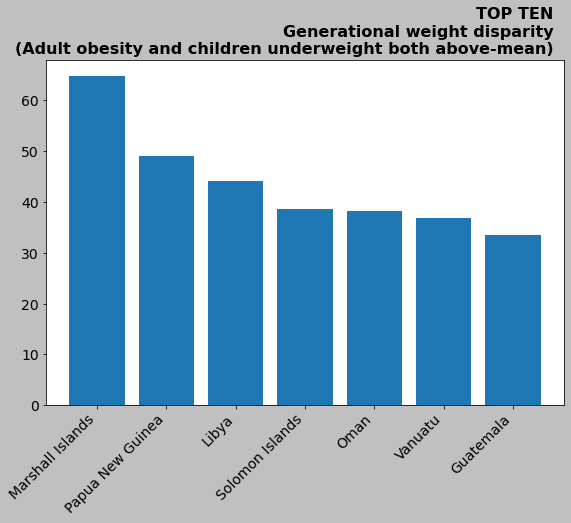

In [33]:
# who has the highest combined score for both adult obesity prevalence and 
# children 4- underweight, where both scores are above feature mean?

uFeat = 'People and Society: Children under the age of 5 years underweight'
oFeat = 'People and Society: Obesity - adult prevalence rate'

df[ 'Generational weight disparity' ] = (df[ uFeat ] + df[ oFeat ])

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, uFeat ].iloc[ 0 ]
    >= df[ uFeat ].mean() and
    df.loc[ df[ 'Country' ] == country, oFeat ].iloc[ 0 ]
    >= df[ oFeat ].mean()) ]

showTopTen( 'Generational weight disparity',
    df[ df[ 'Country' ].isin( aboveMeans ) ],
    subtitle="Adult obesity and children underweight both above-mean" )

People and Society: School life expectancy (primary to tertiary education) - total


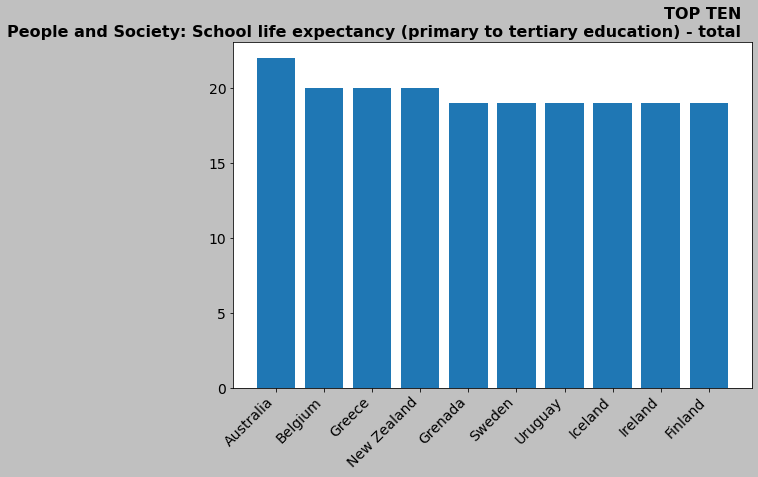

People and Society: School life expectancy (primary to tertiary education) - male


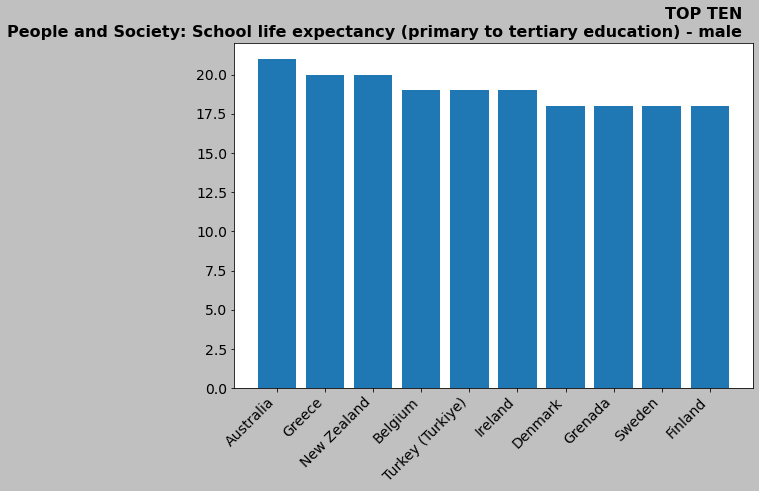

People and Society: School life expectancy (primary to tertiary education) - female


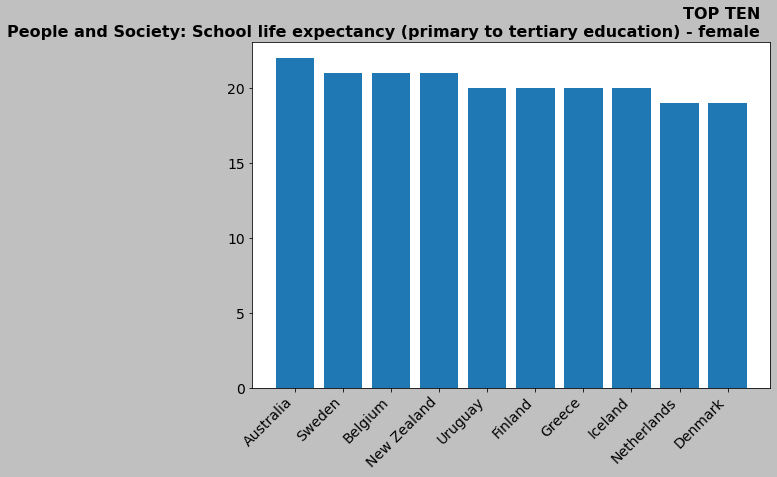

School completion disparity between sexes


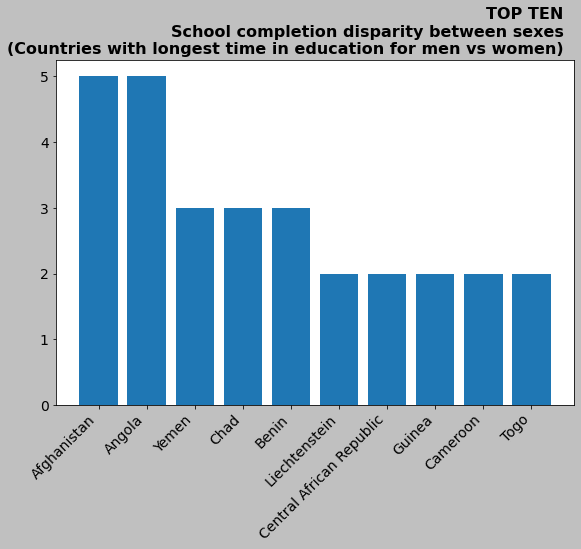

School completion disparity between sexes


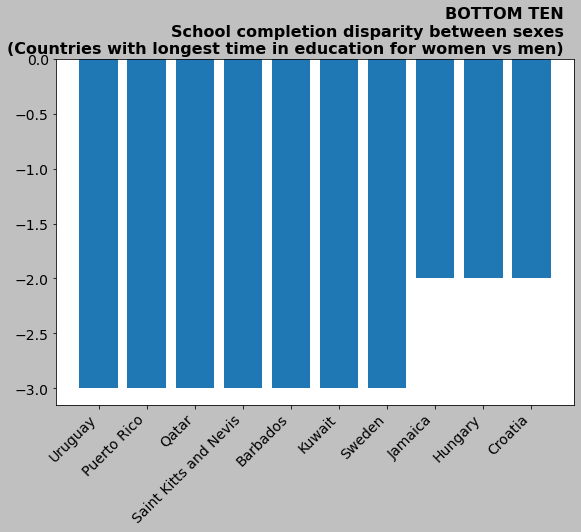

In [34]:
# EDUCATION DISPARITIES:
expectFeatStr = (
    "People and Society: School life expectancy (primary to tertiary "
    "education) -")
showTopTen( f'{expectFeatStr} total', df )
showTopTen( f'{expectFeatStr} male', df )
showTopTen( f'{expectFeatStr} female', df )

# Pat on the back for Aus: by a modest yet significant margin, has the largest
#   percent total competing teriary, AND the position holds true for women as 
#   much as men.

# In terms of largest school-completion disparity in the sexes:
df[ 'School completion disparity between sexes' ] = (
    df[ f'{expectFeatStr} male' ] - df[ f'{expectFeatStr} female' ])

showTopTen( 'School completion disparity between sexes', df,
    subtitle="Countries with longest time in education for men vs women" )
showTopTen( 'School completion disparity between sexes', df, asc=True,
    subtitle="Countries with longest time in education for women vs men" )

# Qatar and Kuwait surprising given [ (an impression of) the distribution
#   for countries in the region. ]
#   (Possible to group results by coordinate or by other "Geography" feature?)

In [35]:
def getRank( _df, ctry, feature ):
    value = _df[ feature ].loc[ _df[ 'Country' ] == ctry ].values[ 0 ]
    if str( value ) == 'nan': return print( f"{ctry} is null for\n{feature}" )
    rank = len( [ v for v in pd.Series( _df[ feature ] ) if v < value ] )
    ties = len( [ v for v in pd.Series( _df[ feature ] ) if v == value ] ) - 1
    print( f"With value of [ {value} ], {ctry} is {rank}th-highest for:\n"
           f"'{feature}'\n(out of total {len( cleanCountries )} ranked)" )
    if ties > 0: print( f"TIED WITH {ties} COUNTRIES" )

Environment: Land use - forest


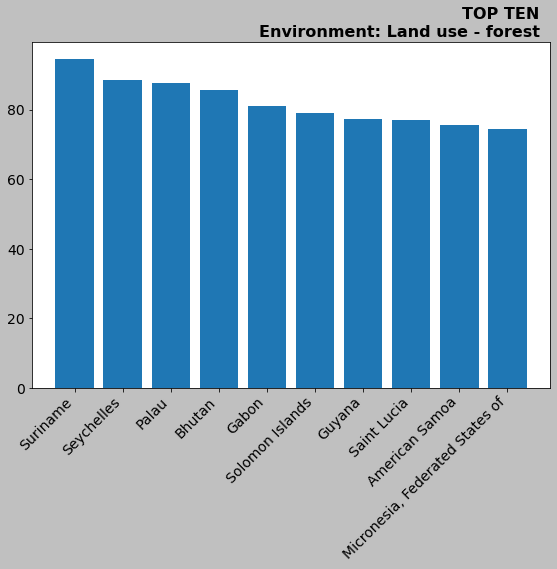

With value of [ 2.36 ], Suriname is 174th-highest for:
'Environment: Revenue from forest resources - forest revenues'
(out of total 258 ranked)


In [36]:

# A pleasant pit-stop in the forests of Suriname:
showTopTen( 'Environment: Land use - forest', df )

# interestingly, Suriname does very little to leverage this as a resource 
#   advantage - Suriname's rank in %rev Forst rsrc is 174th.

getRank( df, 'Suriname',
    'Environment: Revenue from forest resources - forest revenues' )


Environment: Urbanization - urban population


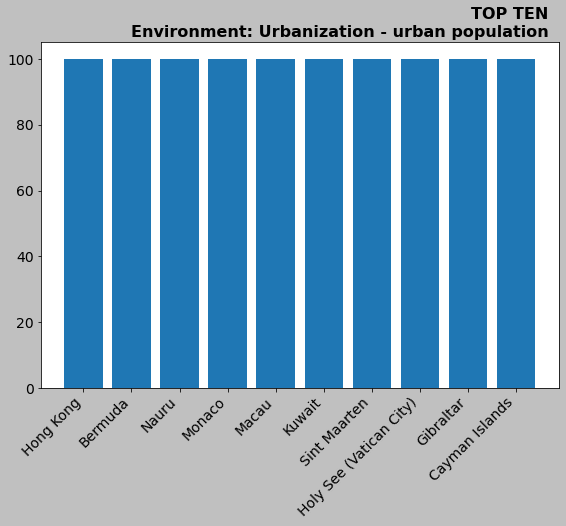

Environment: Urbanization - urban population


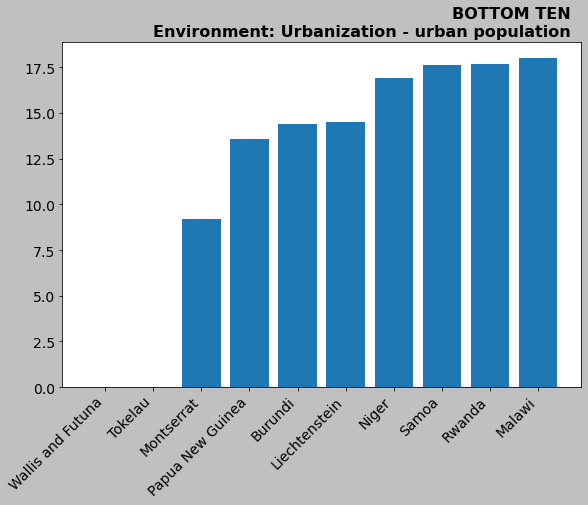

In [37]:
#   Fairly even, City-States understandably dominating the top 10. 
showTopTen( 'Environment: Urbanization - urban population', df )
showTopTen( 'Environment: Urbanization - urban population', df, asc=True )

# Of the least-urbanised, several are pacific territories with relatively 
#   unfamiliar names: Wallis and Futuna (FR), Montserrat (UK) and Tokelau (NZ). 
#   To help with attribution, if not decolonization, I submit that the UK and 
#   French territories swap names.

# Liechtenstein... is also there.
# "It is a testimony to the mere political expediency of the purchase that the Princes of Liechtenstein did not visit 
#   their new principality for almost 100 years." [citation needed]

# for the Kooky Islands Krew
ctIslands.append( 'Wallis and Futuna' )
ctIslands.append( 'Montserrat' )
ctIslands.append( 'Tokelau' )


### COAL
#### Not a glitch: China's appetite

Energy: Coal - Production


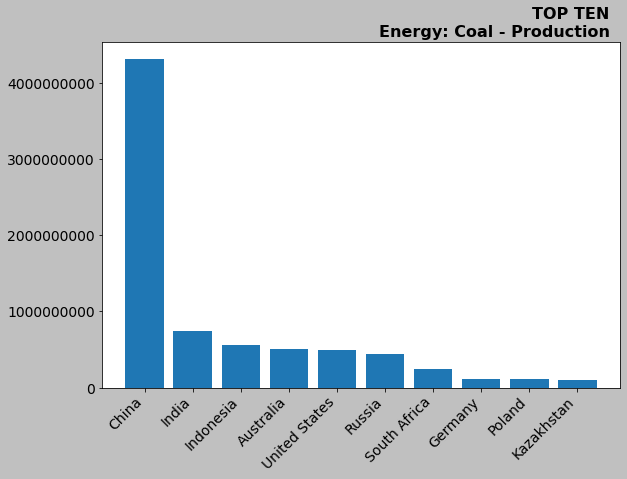

Energy: Coal - Consumption


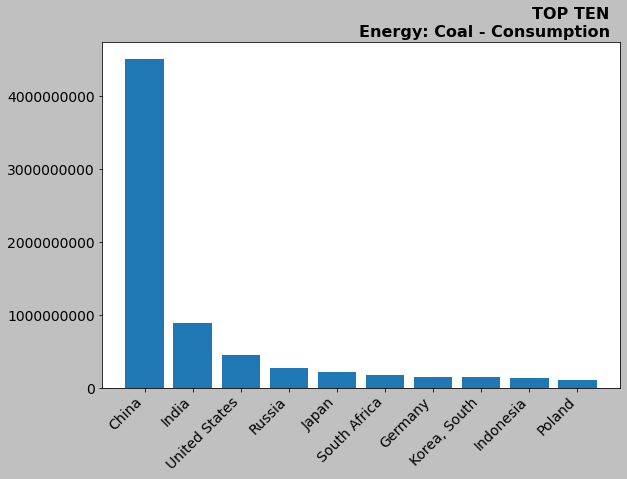

In [38]:
showTopTen( 'Energy: Coal - Production', df )
showTopTen( 'Energy: Coal - Consumption', df )

Just for scale, this is what the production of the top-ten coal producers 
looks like. More astonishingly, China remains a net importer - they consume 
this and more. The equivalent plot for consumption looks the same, except eg.
Australia disappears down to 200th in the world; quite a feat for the fourth-
largest producer, whereas the rest of the top ten producers are in the top ten 
consumers (excepting Kazakhstan, who drops out similarly as consumer to 198th).

In [39]:
# update this to return a percap or perGDP ranking.
getRank( df, 'Australia', 'Energy: Coal - Consumption' )
getRank( df, 'Kazakhstan', 'Energy: Coal - Consumption' )


With value of [ 99048000.0 ], Australia is 200th-highest for:
'Energy: Coal - Consumption'
(out of total 258 ranked)
With value of [ 74819000.0 ], Kazakhstan is 198th-highest for:
'Energy: Coal - Consumption'
(out of total 258 ranked)


Some figures in greater detail:

PRODUCTION: China's production is [ 1.09 ] times that of the rest of the 
world <br>
>   [ 4,314,681,000.00 ]: China's coal production<br>
>   [ 3,974,250,000.00 ]: rest of world combined<br>
 
CONSUMPTION: China's consumption is [ 1.27 ] times that of the rest of the 
world<br>
>   [ 4,506,387,000.00 ]: China's coal consumption<br>
>   [ 3,534,985,000.00 ]: rest of world combined<br>
   

In [40]:
prodFeat = 'Energy: Coal - Production'
consFeat = 'Energy: Coal - Consumption'

chinaProd = df[ df.Country == 'China' ][ prodFeat ].sum()
chinaCsmp = df[ df.Country == 'China' ][ consFeat ].sum()

notChinaProd = df[ df.Country != 'China' ][ prodFeat ].sum()
notChinaCsmp = df[ df.Country != 'China' ][ consFeat ].sum()

# get longest string length to pad report field
pad = (max( [ len( str( i ) )
    for i in [ chinaProd, notChinaProd, chinaCsmp, notChinaCsmp ] ] ))

productReport = (f"PRODUCTION: China's production is "
                 f"[ {(chinaProd / notChinaProd):,.2f} ] times that of the rest of world\n"
                 f"   [ {chinaProd:>{pad},.2f} ]: China's coal production\n"
                 f"   [ {notChinaProd:>{pad},.2f} ]: rest of world combined\n")
consmptReport = (f"\nCONSUMPTION: China's consumption is "
                 f"[ {(chinaCsmp / notChinaCsmp):,.2f} ] times the size\n"
                 f"of the rest of world combined.\n"
                 f"   [ {chinaCsmp:>{pad},.2f} ]: China's coal consumption\n"
                 f"   [ {notChinaCsmp:>{pad},.2f} ]: rest of world combined\n")

print( productReport, consmptReport )

PRODUCTION: China's production is [ 1.09 ] times that of the rest of world
   [ 4,314,681,000.00 ]: China's coal production
   [ 3,974,250,000.00 ]: rest of world combined
 
CONSUMPTION: China's consumption is [ 1.27 ] times the size
of the rest of world combined.
   [ 4,506,387,000.00 ]: China's coal consumption
   [ 3,534,985,000.00 ]: rest of world combined



Energy: Coal - Exports


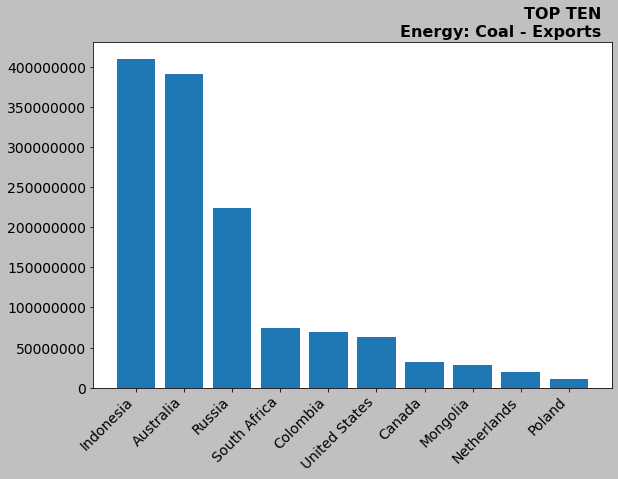

Coal: Exports-to-Total-Holdings ratio


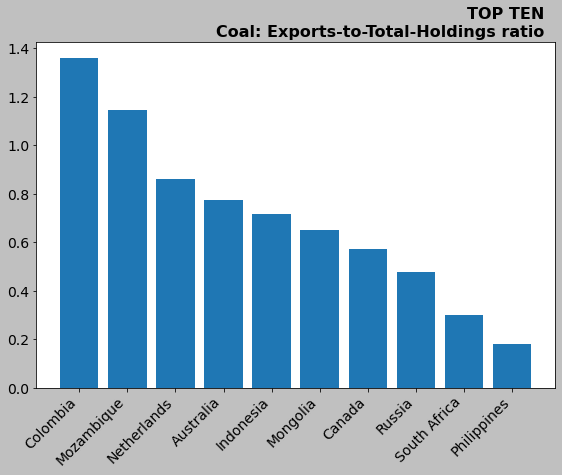

Environment: Revenue from coal - coal revenues


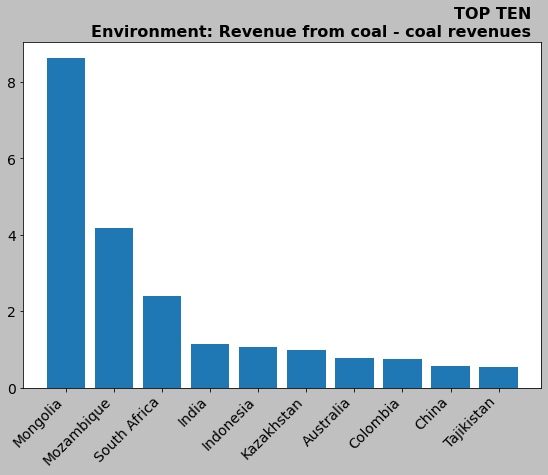

Environment: Air pollutants - carbon dioxide emissions


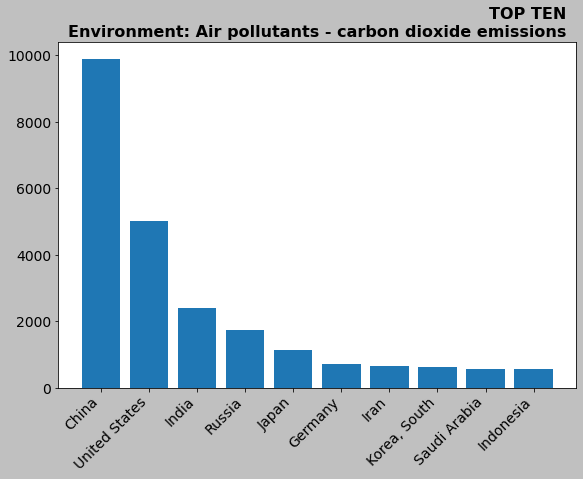

In [41]:
# Corobborating the disparity between production and consumption, the export
#   figures appear as follows.
showTopTen( 'Energy: Coal - Exports', df )

# We can get an image of a country's relationship with coal if we look at the 
#   combined production and imports in ratio to exports. Where this ratio is 
#   above one, a country has exported abve the total it produced and imported,
#   meaning it has sold reserves.
#   Refining this further to only the countries whose exports are above the
#   world-mean, we can see who has a strong reliance on coal exports.

df[ 'Coal: Exports-to-Total-Holdings ratio' ] = (
    df[ 'Energy: Coal - Exports' ] /
    (df[ 'Energy: Coal - Production' ] +
     df[ 'Energy: Coal - Imports' ]))

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, 'Energy: Coal - Exports' ].iloc[ 0 ]
    >= df[ 'Energy: Coal - Exports' ].mean()) ]

showTopTen( 'Coal: Exports-to-Total-Holdings ratio',
    df[ df[ 'Country' ].isin( aboveMeans ) ] )

# In order, the refinement exluded Venezuela, Belarus and Eswatini
# such that Russia, South Africa and the Phillipines entered the t10 "sellers"


# Environment: Revenue from coal - coal revenues
#   "% revenue derived from taxation on coal production"?
#   Compare with "Exports" [...]
showTopTen( 'Environment: Revenue from coal - coal revenues', df )

# Naturally, on the topic of coal, a look at the top CO2 emitters:

showTopTen( 'Environment: Air pollutants - carbon dioxide emissions', df )
#   China leads by twice its nearest competitor, the US. See coal-relation (hah)
# Similar stats for Environment: Air pollutants - methane emission.


Water withdrawal exposure to trade


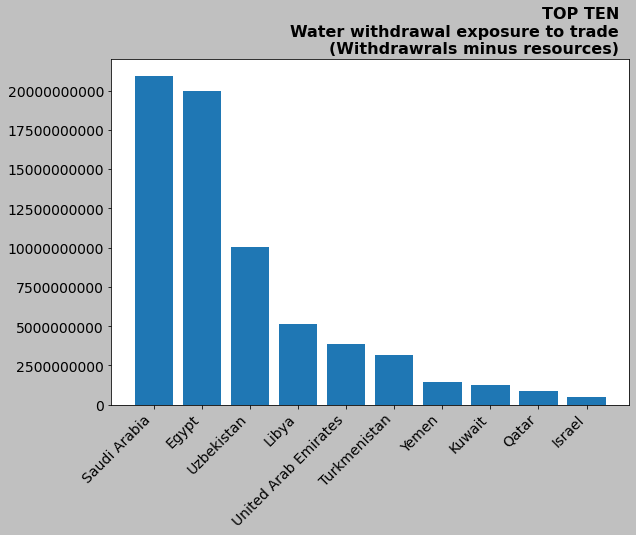

Water withdrawal exposure to trade


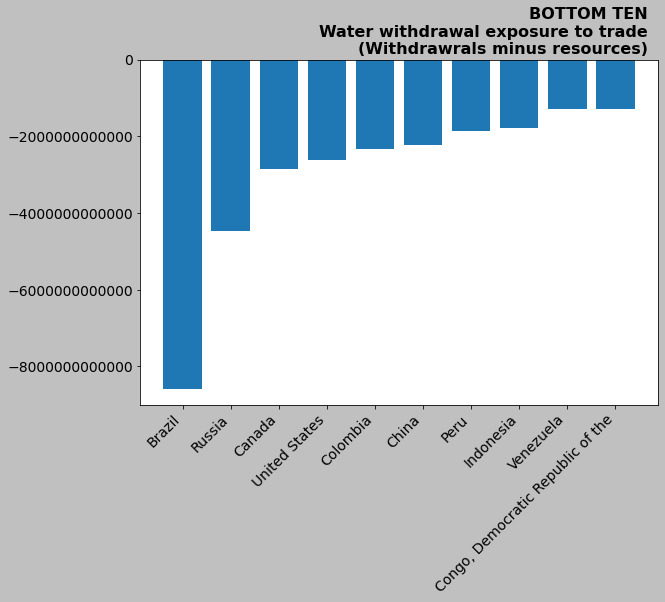

In [42]:
# Who are the most and least trade-reliant for water? (Hi there, Middle East)
# Withdrawrals (municipal, industrial and agricultural) minus renewable sources
df[ 'Water withdrawal exposure to trade' ] = (
    (df[ 'Environment: Total water withdrawal - municipal' ] +
     df[ 'Environment: Total water withdrawal - industrial' ] +
     df[ 'Environment: Total water withdrawal - agricultural' ]) -
    df[ 'Environment: Total renewable water resources' ])

showTopTen( 'Water withdrawal exposure to trade', df,
    subtitle="Withdrawrals minus resources" )

# Brazil is sitting happy there around the Amazon. Russia and Canada just 
# melt vast amounts of snow.
showTopTen( 'Water withdrawal exposure to trade', df, asc=True,
    subtitle="Withdrawrals minus resources" )

In [43]:
ctIslands.append( 'Cape Verde' )
ctIslands.append( 'Saint Vincent and the Grenadines' )
ctIslands.append( 'Saint Kitts and Nevis' )
ctIslands.append( 'Saint Lucia' )

Government: National heritage - total World Heritage Sites


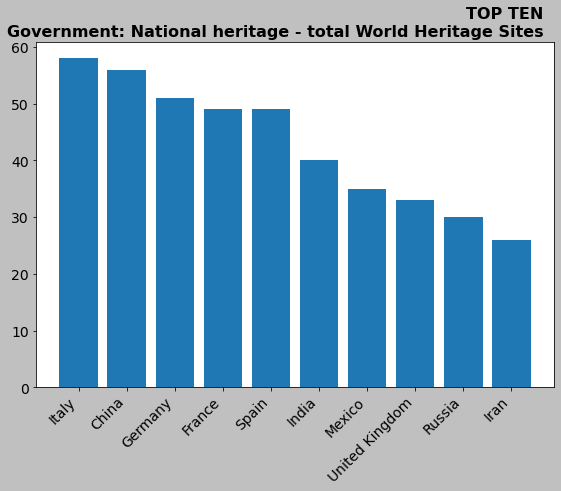

In [44]:
showTopTen( 'Government: National heritage - total World Heritage Sites', df )
# the anti-empire question: what qualifies as world heritage? 
# -> All t10 is high-GDP (corrob.)

Economy: Real GDP (purchasing power parity)


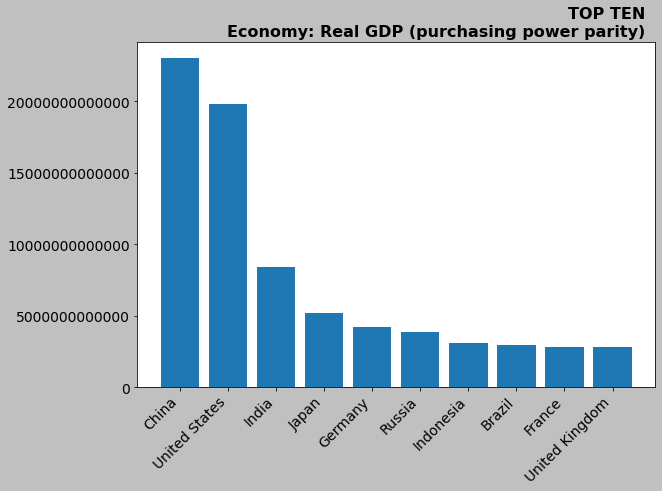

Economy: Real GDP (purchasing power parity)


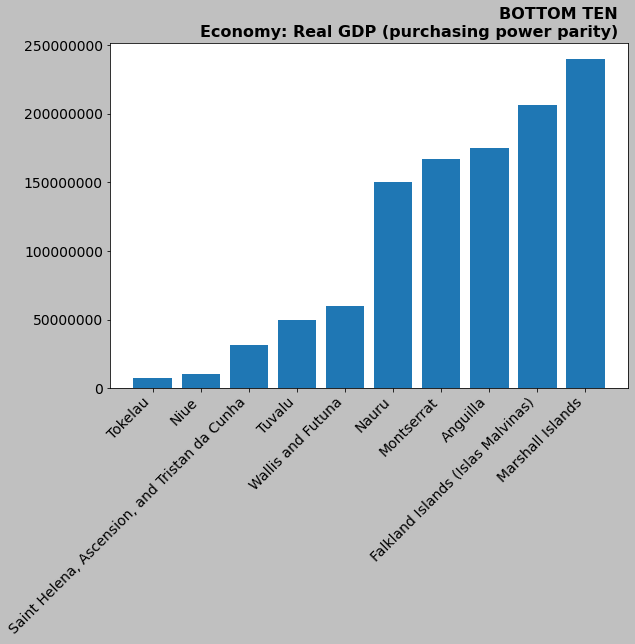

Economy: GDP - composition, by sector of origin - services


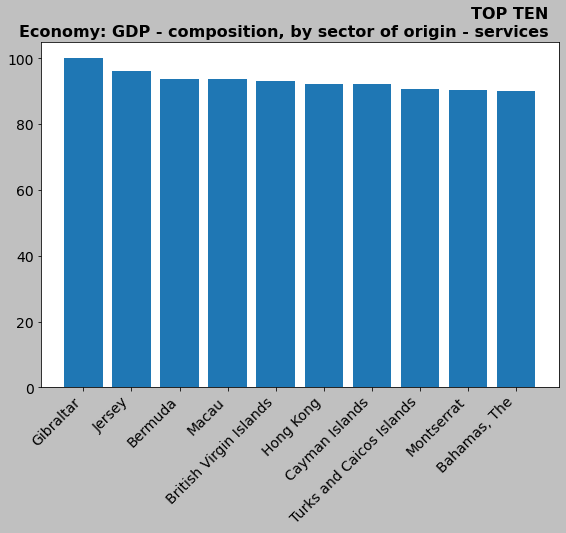

Economy: GDP - composition, by end use - household consumption


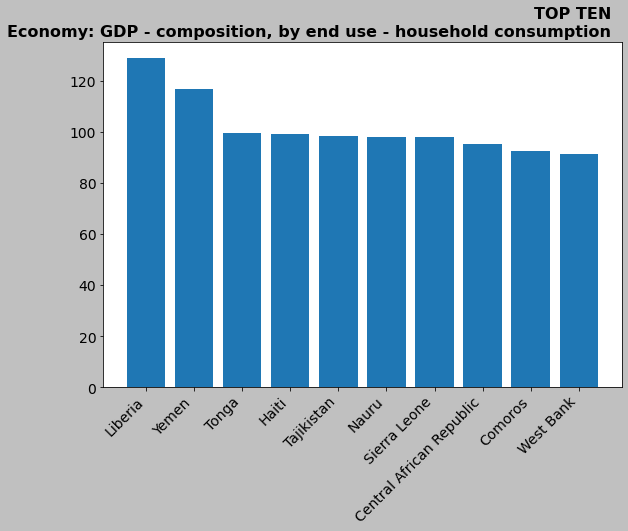

Economy: GDP - composition, by end use - household consumption


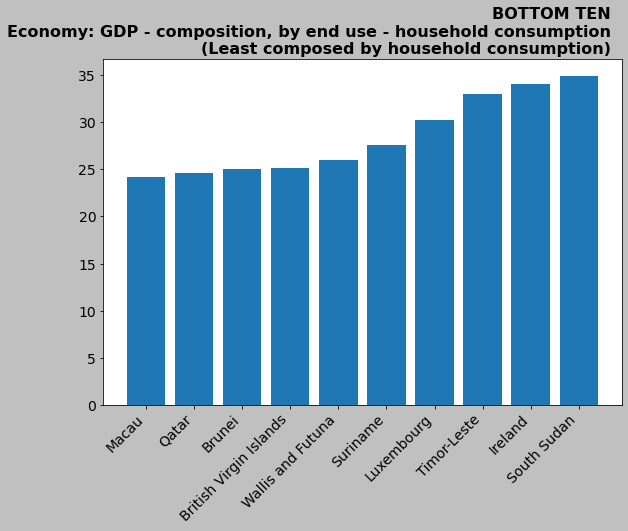

Economy: Inflation rate (consumer prices)


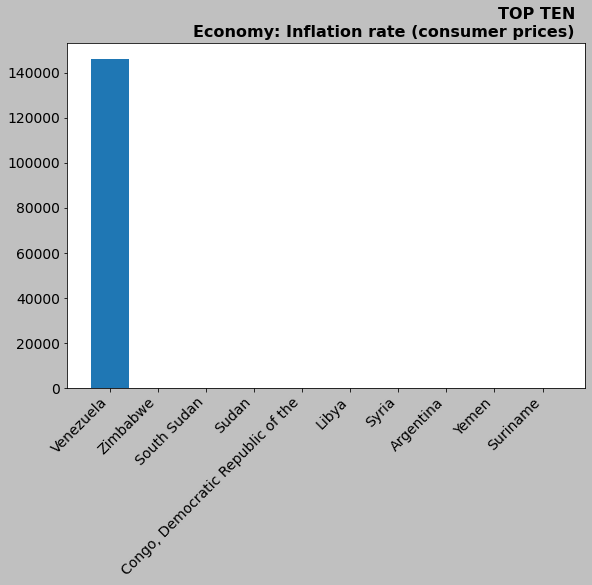

Economy: Inflation rate (consumer prices)


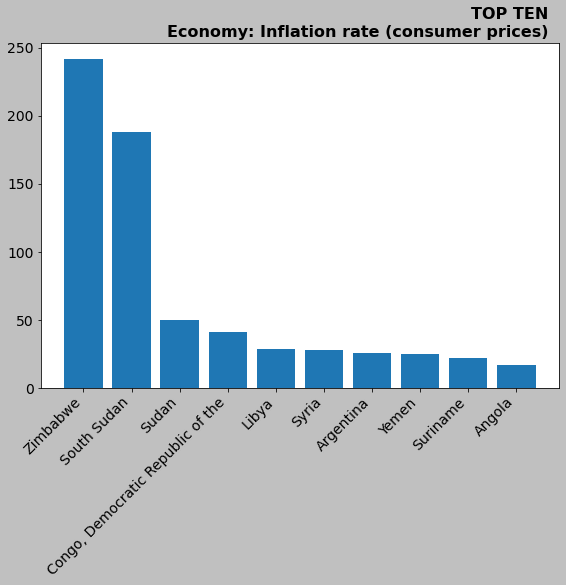

Economy: Inflation rate (consumer prices)


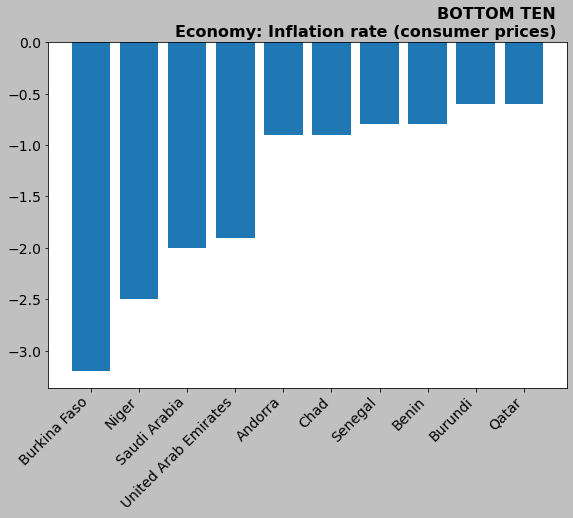

In [45]:
# Economy

# GDP
showTopTen( 'Economy: Real GDP (purchasing power parity)', df )
showTopTen( 'Economy: Real GDP (purchasing power parity)', df, asc=True )
# Economy: Real GDP growth rate
# Economy: Real GDP per capita
# Economy: GDP (official exchange rate)
# Niue, Tokelau and Monstserrat consistenlty coming up in econ-B10s

# Interesting: which sovereignties pay the bills almost entirely from desk-work?
showTopTen( 'Economy: GDP - composition, by sector of origin - services', df )

# GDP driven by household spending. Interesting enough, but how can Liberia and 
#   Yemen be >100%?
# Economy: GDP - composition, by end use - household consumption
showTopTen( 'Economy: GDP - composition, by end use - household consumption', df )
showTopTen( 'Economy: GDP - composition, by end use - household consumption',
    df, asc=True, subtitle="Least composed by household consumption" )
# Economy: GDP - composition, by end use - government consumption
# Economy: GDP - composition, by end use - investment in fixed capital
# Economy: GDP - composition, by end use - investment in inventories

# Again, many places have >100% GDP from exports:
# Economy: GDP - composition, by end use - exports of goods and services
# on this topic: Maldives is a startling sole-case of GDP from G-S imports.
#   Economy: GDP - composition, by end use - imports of goods and services

# Inflation
#   Venezuela dwarfs the world.
showTopTen( 'Economy: Inflation rate (consumer prices)', df )
showTopTen( 'Economy: Inflation rate (consumer prices)',
    df[ df[ 'Country' ] != 'Venezuela' ] )  # without Venezueal
showTopTen( 'Economy: Inflation rate (consumer prices)', df, asc=True )

Labour force as a percentage of population


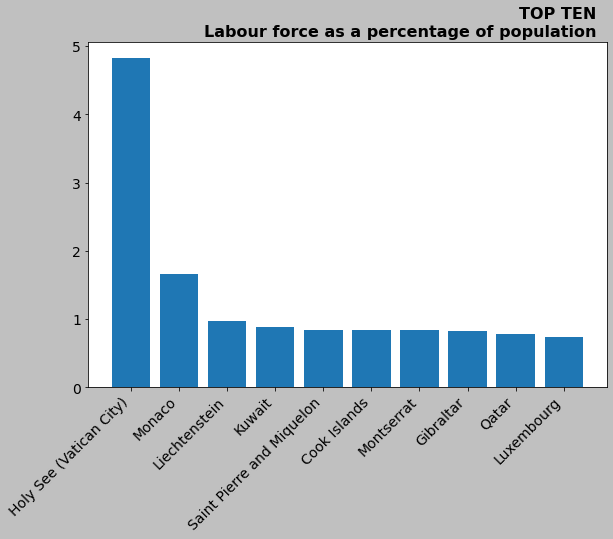

Labour force as a percentage of population


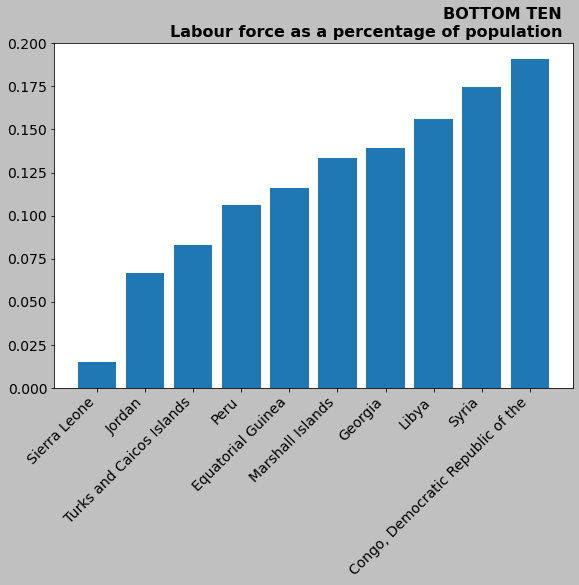

In [46]:
# compare with pop: Economy: Labor force
# Labour force as a percentage of population. 
# LForce obviously includes migrant workers. 
df[ 'Labour force as a percentage of population' ] = (
    df[ 'Economy: Labor force' ] /
    df[ 'People and Society: Population' ])

showTopTen( 'Labour force as a percentage of population', df )
showTopTen( 'Labour force as a percentage of population', df, asc=True )
# In these countries, even including cross-border commuters, there is less than
#   0.2 of a "labour force" indiv. for every indiv. counted in the population.

Economy: Labor force - by occupation - agriculture


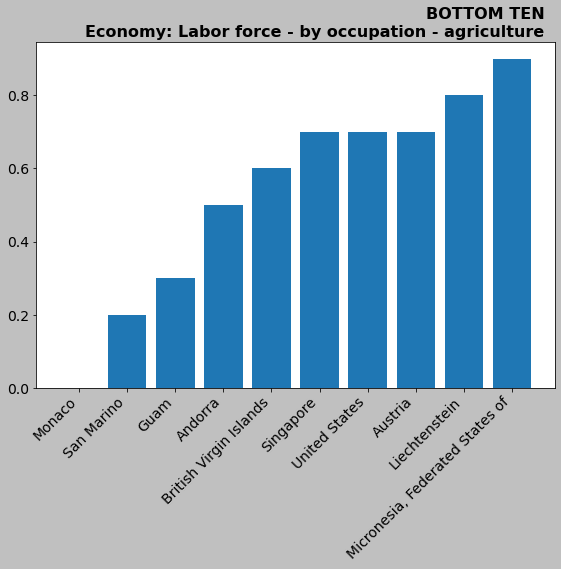

Agriculture: GDP composition to labour


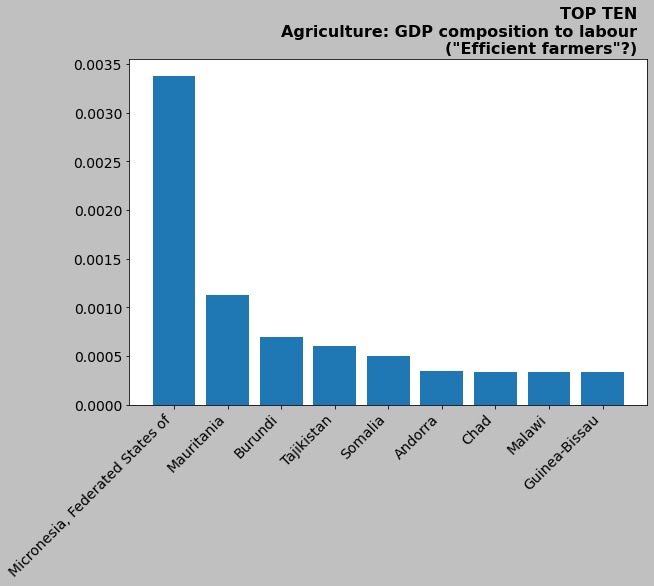

In [47]:
dfPop = pd.concat( [
    dffBook[ 'Country' ],
    dffBook[ 'People and Society: Population' ],
    dffBook[ 'Economy: Labor force' ],
    dffBook[ 'Economy: Labor force - by occupation - agriculture' ] ],
    axis=1 )

tongaLforce = dfPop[ dfPop[ 'Country' ] == "Tonga" ]

# Error in the original data for Tonga (date taken as percent)
# Excluding Tonga, the surprise in the bottom ten is the USA - only ~0.7% of 
#   workers are in agriculture?
showTopTen( 'Economy: Labor force - by occupation - agriculture',
    df[ df[ 'Country' ] != "Tonga" ], asc=True )

# TONGA labour force stats all error (taken date as value)
# print(dffBook[ 'Economy: Labor force - by occupation - agriculture' ].loc[ dffBook[ 'Country' ] == 'Tonga' ].values[ 0 ])
# print(dfFbDict['Economy: Labor force - by occupation - agriculture']['matchedNums'])


# Leads to the question: who has the highest Agri-portion of GDP in ratio to
#   the Agri-portion of the labour force (an estimate of agri-automation?)

df[ 'Agriculture: GDP composition to labour' ] = ((
    df[ 'Economy: GDP - composition, by sector of origin - agriculture' ] /
    df[ 'Economy: GDP (official exchange rate)' ])) / ((
    df[ 'Economy: Labor force - by occupation - agriculture' ] /
    df[ 'Economy: Labor force' ]))

showTopTen( 'Agriculture: GDP composition to labour',
    df[ df[ 'Country' ] != "Tonga" ], subtitle="\"Efficient farmers\"?" )

Economy: Gini Index coefficient - distribution of family income


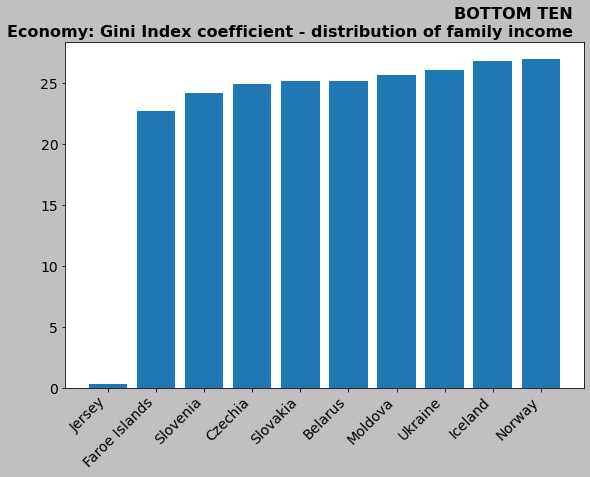

Economy: Gini Index coefficient - distribution of family income


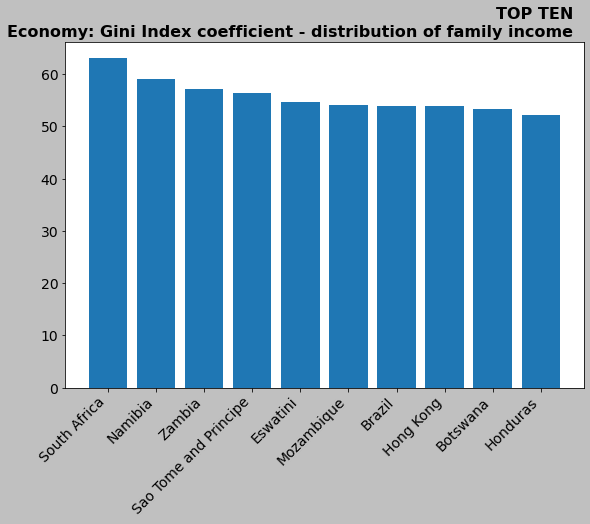

In [48]:
# The most-equal countries have a strong representation of East 
# Eurpoean countries, along with Social Democracy commentators' darling, 
#   Norway. Jersey and Faroe would need to be more closely vetted.
showTopTen( 'Economy: Gini Index coefficient - distribution of family income',
    df, asc=True )

# The least-equal countries most strongly feature Southern African nations.
showTopTen( 'Economy: Gini Index coefficient - distribution of family income',
    df )

In [49]:
# Continuing t10 analysis from progress:
listStart = 99
showNumber = 1

FEAT 99-100 of 208
Economy: GDP - composition, by end use - investment in fixed capital


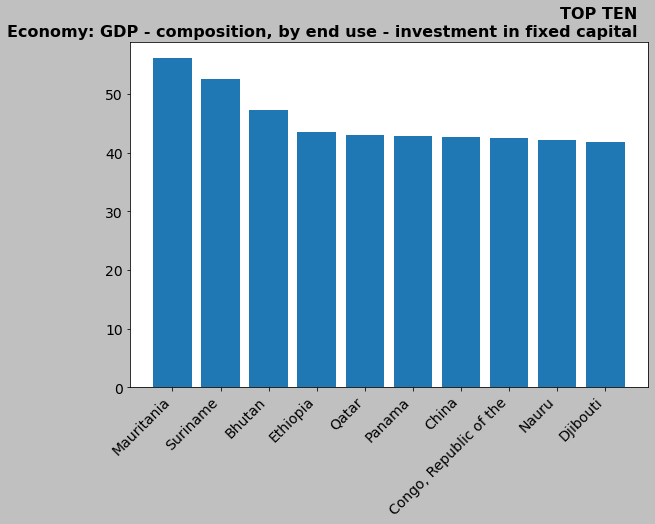

In [50]:
print( f"FEAT {listStart}-{listStart + showNumber} of {len( df.columns )}" )
for i in list( df.columns )[ listStart:listStart + showNumber ]:
    showTopTen( i, df )
    listStart += showNumber

In [51]:
# Generate "unit dict" which "show t10" fetches by column key

In [52]:
newDrops = [
    'Government: Country name - etymology',
    'Economy: Real GDP per capita - note',
    'Government: Suffrage'
    ]

In [53]:
# the Kooky Islands Krew (ctIslands)
#   appears frequently on the bottom/top ten because it is takes less
#   of an event in global terms to have a proportionately large effect
#   on the small sample, be it a population, an area total and so on. 

# Things that China is in the top-ten/5/3/1 of
# (Who else are the "most top 10/5/3/1" countries?)
# combine bottom-tens somehow?

In [54]:
# Generate CORRELATION DICTIONARY where keys are feature pairs,
#   using frozensets as keys for reversible feat lookup
#   values are correlations.

fset = frozenset
correlDict = { }
baseCol = 1
while True:
    # for each feat, get any correls for feats to the right 
    for colPos in range( baseCol + 1, df.shape[ 1 ] ):
        correlns = df.iloc[ :, baseCol ].corr( df.iloc[ :, colPos ] )
        correlDict.update( { fset( [ baseCol, colPos ] ): correlns } )
    
    baseCol += 1
    if baseCol == df.shape[ 1 ]: print( f"Completed correlations" ); break


Completed correlations


In [55]:
# Examine features with correlations within specified threshold
# explore different thesholds

def correlDct( inn_lim, out_lim = float( 'inf' ) ):
    """collect feature correlations within specified significance range"""
    threshDict = { }
    for key in correlDict:
        corr = correlDict[ key ]
        bCol = list( key )[ 0 ]
        cCol = list( key )[ 1 ]
        if (-out_lim < corr <= -inn_lim) or (inn_lim <= corr < out_lim):
            threshDict[ key ] = {
                'corr': corr,
                'inn_lim': inn_lim,
                'baseCol': bCol,
                'compCol': cCol,
                'out_lim': out_lim if out_lim != float( 'inf' ) else "inf",
                'baseName': df.columns[ bCol ],
                'compName': df.columns[ cCol ] }
    return threshDict


def thresholdReport( tDct, _key ):
    """output feature detail for sig range """
    colRef = str( list( _key ) )
    record = tDct[ _key ]
    corr = record[ 'corr' ]
    inn_lim = record[ 'inn_lim' ]
    out_lim = record[ 'out_lim' ]
    baseName = record[ 'baseName' ]
    compName = record[ 'compName' ]
    return (
        f"CORRELATION FOR FEAT-PAIR {colRef}"
        f"\nIN THRESHOLD +-=[ {inn_lim}-{out_lim} ] "
        f"\nCORR: {corr}"
        f"\nBASE: {baseName}"
        f"\nCOMP: {compName}\n")



In [56]:
# Check perfect correlations (likely duplicate features)
thresh_1_0 = correlDct( 1 )
for i in thresh_1_0: print( thresholdReport( thresh_1_0, i ) )

CORRELATION FOR FEAT-PAIR [72, 9]
IN THRESHOLD +-=[ 1-inf ] 
CORR: 1.0
BASE: Environment: Land use - agricultural land
COMP: Geography: Land use - agricultural land

CORRELATION FOR FEAT-PAIR [73, 10]
IN THRESHOLD +-=[ 1-inf ] 
CORR: 1.0
BASE: Environment: Land use - forest
COMP: Geography: Land use - forest

CORRELATION FOR FEAT-PAIR [75, 27]
IN THRESHOLD +-=[ 1-inf ] 
CORR: 1.0
BASE: Environment: Urbanization - urban population
COMP: People and Society: Urbanization - urban population

CORRELATION FOR FEAT-PAIR [28, 76]
IN THRESHOLD +-=[ 1-inf ] 
CORR: 1.0
BASE: People and Society: Urbanization - rate of urbanization
COMP: Environment: Urbanization - rate of urbanization

CORRELATION FOR FEAT-PAIR [68, 111]
IN THRESHOLD +-=[ 1-inf ] 
CORR: 1.0
BASE: People and Society: Unemployment, youth ages 15-24 - female
COMP: Economy: Unemployment, youth ages 15-24 - female



In [57]:
# Confirmed duplicates, dropping.
for i in thresh_1_0: correlDict.pop( i )

In [58]:
# Lower threshold, likely still duplicates with some noise
thresh_9_9_9 = correlDct( 0.999 )
for i in thresh_9_9_9: print( f"{thresholdReport( thresh_9_9_9, i )}" )

CORRELATION FOR FEAT-PAIR [1, 2]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.999505442417599
BASE: Geography: Area - total
COMP: Geography: Area - land

CORRELATION FOR FEAT-PAIR [74, 11]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: Environment: Land use - other
COMP: Geography: Land use - other

CORRELATION FOR FEAT-PAIR [66, 109]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: People and Society: Unemployment, youth ages 15-24 - total
COMP: Economy: Unemployment, youth ages 15-24 - total

CORRELATION FOR FEAT-PAIR [67, 110]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: People and Society: Unemployment, youth ages 15-24 - male
COMP: Economy: Unemployment, youth ages 15-24 - male



In [59]:
# Check differences, filtering out NaN-only differences

def showUnequalNonNaN( tDict ):
    """Identify and report value differences between correlated features"""
    difDct = { }
    for k in tDict:
        bCol, cCol = [ df.columns[ i ] for i in list( k ) ]
        dfCompare = df[ [ bCol, cCol ] ].loc[ ~(df[ bCol ] == df[ cCol ]) ]
        if len( dfCompare.dropna() ) < 1: print( f"{list( k )}: diffs all NaN" )
        else: difDct.update( { k: dfCompare } )
    if len( difDct ) < 1: print( "\nREPORTING NON-NAN DIFFERENCES CORR. FEATS" )
    for k in difDct:
        difDf = pd.concat( [ df[ 'Country' ], difDct[ k ] ], axis=1 ).dropna()
        print( f"\n{len( difDf )} Non-NaN diffs for {list( k )}. First 3:" )
        display( HTML( difDf[ :3 ].to_html() ) )
    return difDct


checkDifs_9_9_9 = showUnequalNonNaN( thresh_9_9_9 )
# Proof: having more land almost always makes your country bigger!
# For same feature name: at this range, all diffs NaN,
#   but NaN at different positions? Does merging cols enhance the feature? 

[74, 11]: diffs all NaN
[66, 109]: diffs all NaN
[67, 110]: diffs all NaN

160 Non-NaN diffs for [1, 2]. First 3:


,Country,Geography: Area - total,Geography: Area - land
2,Albania,"28,748.00","27,398.00"
10,Argentina,"2,780,400.00","2,736,690.00"
11,Armenia,"29,743.00","28,203.00"


In [60]:
thresh_995_999 = correlDct( 0.995, 0.999 )
for i in thresh_995_999: print( f"{thresholdReport( thresh_995_999, i )}" )
checkDifs_995_998 = showUnequalNonNaN( thresh_995_999 )

CORRELATION FOR FEAT-PAIR [20, 21]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9965314599297501
BASE: People and Society: Median age - total
COMP: People and Society: Median age - male

CORRELATION FOR FEAT-PAIR [38, 39]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9985392452149099
BASE: People and Society: Infant mortality rate - total
COMP: People and Society: Infant mortality rate - male

CORRELATION FOR FEAT-PAIR [40, 38]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9976671587641676
BASE: People and Society: Infant mortality rate - female
COMP: People and Society: Infant mortality rate - total

CORRELATION FOR FEAT-PAIR [83, 205]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: -0.9960151442525876
BASE: Environment: Total renewable water resources
COMP: Water withdrawal exposure to trade

CORRELATION FOR FEAT-PAIR [116, 117]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9970410009171566
BASE: Economy: Budget - revenues
COMP: Economy: Budget - expenditures

CORRELATION FOR FEAT-PAIR [128, 129]
IN THRESHOLD +

,Country,People and Society: Median age - total,People and Society: Median age - male
0,Afghanistan,19.50,19.40
2,Albania,34.30,32.90
3,Algeria,28.90,28.60



226 Non-NaN diffs for [38, 39]. First 3:


,Country,People and Society: Infant mortality rate - total,People and Society: Infant mortality rate - male
0,Afghanistan,104.89,113.33
2,Albania,10.82,11.85
3,Algeria,19.72,21.77



226 Non-NaN diffs for [40, 38]. First 3:


,Country,People and Society: Infant mortality rate - female,People and Society: Infant mortality rate - total
0,Afghanistan,96.03,104.89
2,Albania,9.71,10.82
3,Algeria,17.55,19.72



176 Non-NaN diffs for [83, 205]. First 3:


,Country,Environment: Total renewable water resources,Water withdrawal exposure to trade
0,Afghanistan,"65,330,000,000.00","-44,957,100,000.00"
2,Albania,"30,200,000,000.00","-28,780,200,000.00"
3,Algeria,"11,667,000,000.00","-1,205,000,000.00"



224 Non-NaN diffs for [116, 117]. First 3:


,Country,Economy: Budget - revenues,Economy: Budget - expenditures
0,Afghanistan,"2,276,000,000.00","5,328,000,000.00"
2,Albania,"3,614,000,000.00","3,874,000,000.00"
3,Algeria,"54,150,000,000.00","70,200,000,000.00"



210 Non-NaN diffs for [128, 129]. First 3:


,Country,Energy: Electricity - Installed generating capacity,Energy: Electricity - Consumption
0,Afghanistan,"776,000.00","5,913,090,000.00"
2,Albania,"2,531,000.00","6,527,980,000.00"
3,Algeria,"21,694,000.00","66,646,000,000.00"



105 Non-NaN diffs for [160, 142]. First 3:


,Country,Energy: Carbon dioxide emissions - From coal and metallurgical coke,Energy: Coal - Consumption
0,Afghanistan,"4,158,000.00","2,096,000.00"
3,Algeria,"352,000.00","85,000.00"
14,Australia,162.26,"99,048,000.00"



182 Non-NaN diffs for [160, 189]. First 3:


,Country,Energy: Carbon dioxide emissions - From coal and metallurgical coke,Transportation: Roadways - total
0,Afghanistan,"4,158,000.00","34,903.00"
3,Algeria,"352,000.00","104,000.00"
4,American Samoa,0.00,241.00



166 Non-NaN diffs for [178, 181]. First 3:


,Country,Transportation: Airports - with paved runways - total,"Transportation: Airports - with paved runways - 1,524 to 2,437 m"
0,Afghanistan,29.00,12.00
2,Albania,3.00,1.00
3,Algeria,67.00,18.00


In [77]:
# The plot thickens, and yet becomes scattered...

# Stronger correlations will tend to be more obvious, but provide an 
#   empirical, observational basis for testing easy assumptions. 
#   Scatter plots are useful for identifying or demonstrating where a clear 
#       pattern, like a linear correlation, is present, and also for 
#       an alternative view on observations made with different techniques.

def plotScttr( _df, fts ):
    bCol, cPos = [ list( _df.columns ).index( ft ) for ft in fts ]
    print( f"Feats: [ {fts[ 0 ]} ]\n       [ {fts[ 1 ]} ]"
           f"\n       CORRELATION: {correlDict[ fset( [ bCol, cPos ] ) ]}" )
    plt.plot( _df[ fts[ 0 ] ], df[ fts[ 1 ] ], 'o', color='black' )
    plt.show()


def plotScttrDbl( _df, fts, fts2 ):
    for ft in [ fts, fts2 ]: print( f"Fts: [ {ft[ 0 ]} ]\n     [ {ft[ 1 ]} ]" )
    fig, (ax1, ax2) = plt.subplots( 1, 2, sharey='all' )  # 1 row, 2 col
    ax1.scatter( _df[ fts[ 0 ] ], _df[ fts[ 1 ] ], c='blue' )
    ax2.scatter( _df[ fts2[ 0 ] ], _df[ fts2[ 1 ] ], c='red' )
    ax1.set_xlabel( fts[ 1 ] )
    ax2.set_xlabel( fts2[ 1 ] )
    plt.show()

Feats: [ Economy: Budget - revenues ]
       [ Economy: Budget - expenditures ]
       CORRELATION: 0.9970410009171566


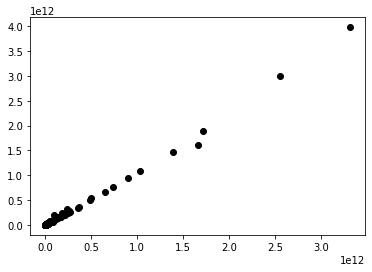

In [78]:
# for corrRef in thresh_995_999:
#     plotScttr( df, [ df.columns[ i ] for i in corrRef ] )

# If you tend to assume that countries usually spend close to what they make in 
#   revenue, take confidence from seeing how both rise together in 
#   very close proportion all the way from lowest to highest.
plotScttr( df, [
    'Economy: Budget - revenues',
    'Economy: Budget - expenditures' ] )

Feats: [ Energy: Coal - Consumption ]
       [ Energy: Carbon dioxide emissions - From coal and metallurgical coke ]
       CORRELATION: 0.9976848477738182


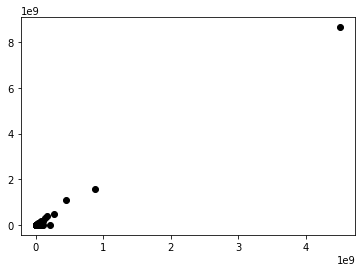

Coal/Metalurgical CO2 emissions BY Coal consumption


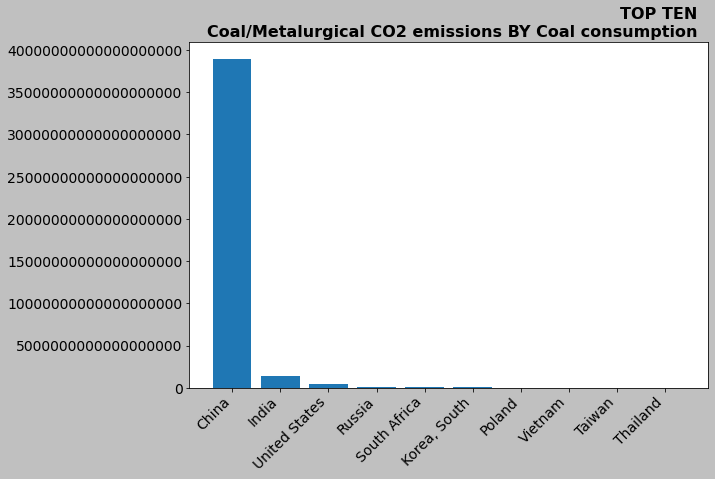

Coal/Metalurgical CO2 emissions PER Coal consumption


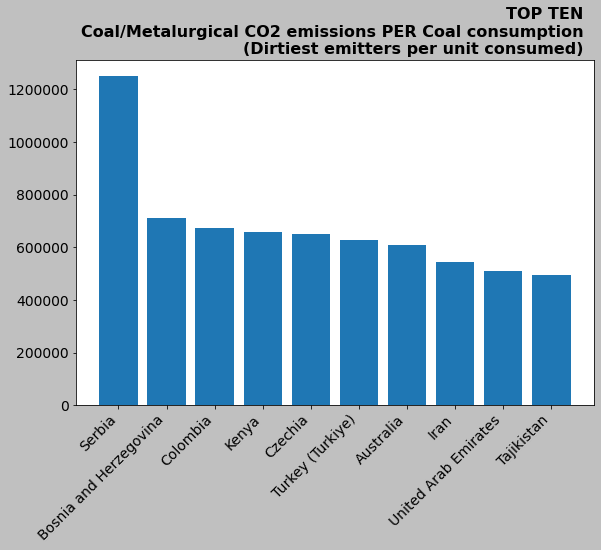

Coal/Metalurgical CO2 emissions PER Coal consumption


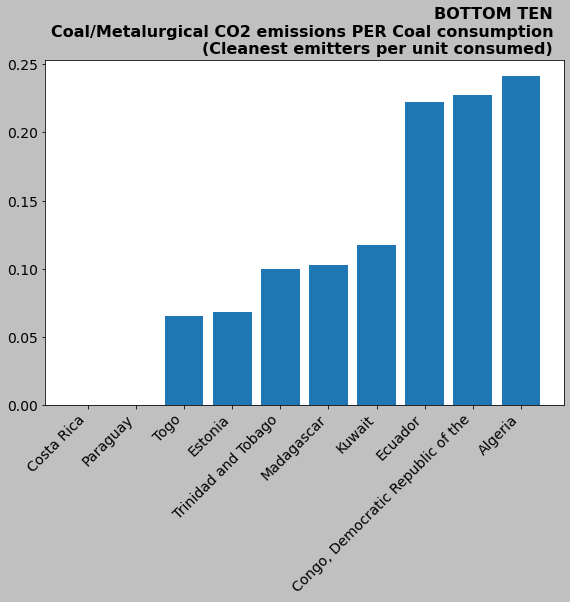

With value of [ 1000.0 ], Costa Rica is 110th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 258 ranked)


With value of [ 0.0 ], Costa Rica is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 258 ranked)
TIED WITH 85 COUNTRIES


With value of [ 3000.0 ], Paraguay is 111th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 258 ranked)


With value of [ 0.0 ], Paraguay is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 258 ranked)
TIED WITH 85 COUNTRIES




In [85]:
# CO2 EMISSIONS

# The world's clustering for CO2 emissions vs coal consumption
#   China off in the distance
yFeat = 'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
plotScttr( df, [ 'Energy: Coal - Consumption', yFeat ] )

# identifying the extremes (each x by common y). 
df[ 'Coal/Metalurgical CO2 emissions BY Coal consumption' ] = (
    df[ yFeat ] * df[ 'Energy: Coal - Consumption' ])

showTopTen( 'Coal/Metalurgical CO2 emissions BY Coal consumption', df )

# While we are looking at these features, an interesting insight:
#   Scoring the dirtiest coal consumption. Hi there Australia!

df[ 'Coal/Metalurgical CO2 emissions PER Coal consumption' ] = (
    df[ 'Energy: Coal - Consumption' ] / df[ yFeat ])

showTopTen( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    subtitle='Dirtiest emitters per unit consumed' )
showTopTen( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    subtitle='Cleanest emitters per unit consumed', asc=True )
    
# Missing data for costa rica and paraguay?  - go back and dropna
for country in [ "Costa Rica", "Paraguay" ] :
    for feat in [ 
        'Energy: Carbon dioxide emissions - From coal and metallurgical coke',
        'Energy: Coal - Consumption'
        ]: getRank( df, country, feat ); print('\n')

In [81]:
# We may not see anything particularly surprising until considerably lower
#   correlation significance levels; "lower" but still strong (0.5+ is 
#   considered "significant", and we will stop long before dipping below that.)

Feats: [ People and Society: Age structure - 65 years and over ]
       [ People and Society: Age structure - 0-14 years ]
       CORRELATION: -0.8045322602557522


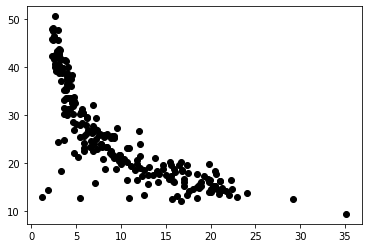

Feats: [ People and Society: Birth rate ]
       [ People and Society: Age structure - 15-24 years ]
       CORRELATION: 0.8166182052227818


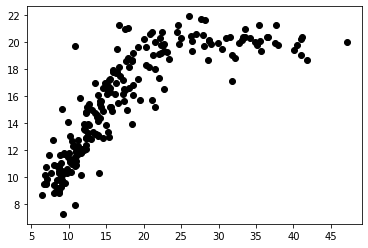

Feats: [ People and Society: Age structure - 55-64 years ]
       [ People and Society: Urbanization - rate of urbanization ]
       CORRELATION: -0.8334763413686379


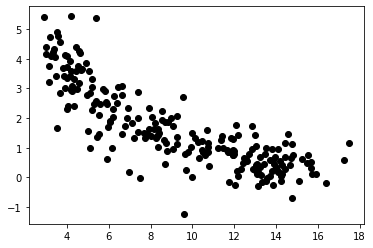

Feats: [ People and Society: Age structure - 55-64 years ]
       [ Communications: Broadband - fixed subscriptions - subscriptions per 100 inhabitants ]
       CORRELATION: 0.8049463091070967


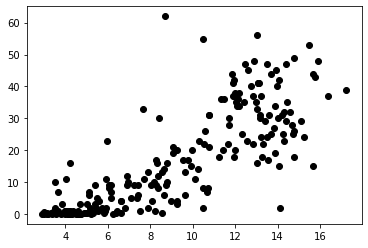

Feats: [ People and Society: Age structure - 65 years and over ]
       [ Communications: Broadband - fixed subscriptions - subscriptions per 100 inhabitants ]
       CORRELATION: 0.8194953381608963


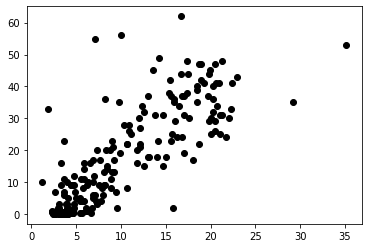

Feats: [ Economy: Real GDP per capita ]
       [ People and Society: Mother's mean age at first birth ]
       CORRELATION: 0.8068605165529785


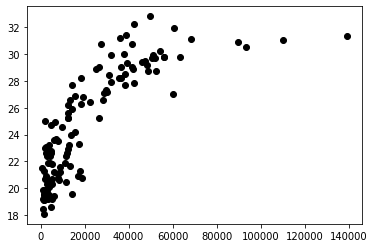

Feats: [ People and Society: School life expectancy (primary to tertiary education) - female ]
       [ People and Society: Infant mortality rate - male ]
       CORRELATION: -0.8040627250445486


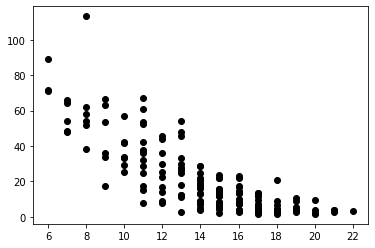

In [83]:
# Birth, age and mortality

# Tasty curvilinear distribution evident here;
#   ++%pop==65+ has neatly acute-to-flat negative correl. with ++%pop==<15
#   "The most juniors (50%) is strongly matched with the least seniors (<5%), 
#       a correlation that quickly flattens out when %juniors gets below 20% 
plotScttr( df, [
    'People and Society: Age structure - 65 years and over',
    'People and Society: Age structure - 0-14 years' ] )

# The strong association of "higher birthrate with a bigger proportion of the 
#   pop%15-24yo" rapidly decreases after the birthrate hits around 20%;
#   after this point, that segment is relatively stable for higher birthrates. 
plotScttr( df, [
    'People and Society: Birth rate',
    'People and Society: Age structure - 15-24 years' ] )

# "Older pop = lower urb'stn" (curvilinear) yet more br'band subs"
plotScttr( df, [
    'People and Society: Age structure - 55-64 years',
    'People and Society: Urbanization - rate of urbanization' ] )
plotScttr( df, [
    'People and Society: Age structure - 55-64 years',
    f'Communications: Broadband - fixed subscriptions - '
    f'subscriptions per 100 inhabitants' ] )
plotScttr( df, [
    'People and Society: Age structure - 65 years and over',
    f'Communications: Broadband - fixed subscriptions - subscriptions '
    f'per 100 inhabitants' ] )
# Higher med. age = +physicians, -fertility, +broadband subscriptions

# Mothers are older in richer countries;
#   acutely so for gdp<"40000", then immediately flattening out 
plotScttr( df, [
    "Economy: Real GDP per capita",
    "People and Society: Mother's mean age at first birth" ] )

# An insight for the bottom-ten countries for female school-life expectancy:
#   Educating women is strongly correlated with male birth survival.
plotScttr( df, [
    f'People and Society: School life expectancy '
    f'(primary to tertiary education) - female',
    'People and Society: Infant mortality rate - male' ] )

In [65]:
# FINALIZING:
# "Question": what snapshot insights can be gathered about the
#   distribution of countries in observations on demographics, economy and energy?

# add mlearn aspect?
# Group t10s and scatterplots by subject.
# move all/most defs to imports, except where important for process comm.
# Fit to QDAVI or other anltc cycle 


# Heh. mosdef.

# END